# Figures for the Entrainment 1 and 2 paper

In [1]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
import seaborn as sns
from scipy import stats
from itertools import combinations, product

In [2]:
dir = '/data/lafe/20170808_col/throughevening/'
outdir = '/data/OneDrive/Tessa Rosenberger/methodologypaper/'
date = '20170808'
td = 'allday'


if td == 'morning':
    timeofday = 'Morning (0800-1200 CDT)'
    local_start = 8
    local_end = 12
elif td == 'afternoon':
    timeofday = 'Afternoon (1200-1700 CDT)'
    local_start = 12
    local_end = 17
elif td == 'allday':
    timeofday = 'All Day (0800-1700 CDT)'
    local_start = 8
    local_end = 17

t0 = local_start -3 # start hour in the data
t1 = local_end -3 # end hour in the data
noon = 9*3600 # the noon hour in the data
adj = local_start - t0 # the difference between the time in the data and local time
start = t0*3600 # start time in seconds
end = t1*3600 # end time in seconds
one_window = 180 #window 30 min
ksurf = 3 # surface layer
order = 3
window_list = np.arange(4,360,3) # the averaging window for the flux calculations
cp = 1.004
Lv = 2.5e3

In [3]:
# define the x and y locations of the columns
x_file=[0,80,160,240,320,400,480,560,0,80,160,240,320,400,480,560,0,80,160,240,320,400,480,560,0,80,160,240,320,400,480,560,0,80,160,240,320,400,480,560,0,80,160,240,320,400,480,560,0,80,160,240,320,400,480,560,0,80,160,240,320,400,480,560]
y_file=[0,0,0,0,0,0,0,0,80,80,80,80,80,80,80,80,160,160,160,160,160,160,160,160,240,240,240,240,240,240,240,240,320,320,320,320,320,320,320,320,400,400,400,400,400,400,400,400,480,480,480,480,480,480,480,480,560,560,560,560,560,560,560,560]

# loop through to get the filenames
filenames = np.empty(len(x_file),dtype=object)
for i in range(len(x_file)):
    filenames[i] ='testbed.column.'+str(format(int(y_file[i]),'05d'))+'.'+str(format(int(x_file[i]),'05d'))+'.0000000.nc'


In [4]:
prof_all = xr.open_dataset(dir + 'merged_prof_from_all_columns.nc', decode_times=False)
timeadj = prof_all['time'].to_numpy()
time_real = prof_all['time'].to_numpy()
time_idx = np.where(np.in1d(time_real,timeadj))[0]
zadj = prof_all['z'].to_numpy()
z_real = prof_all['z'].to_numpy()
z_idx = np.where(np.in1d(z_real,zadj))[0]
zhadj = prof_all['zh'].to_numpy()
zh_real = prof_all['zh'].to_numpy()
zh_idx = np.where(np.in1d(zh_real,zhadj))[0]
time = prof_all['time'][time_idx]
#time = prof_all['time']
time = xr.DataArray(time, coords={'time':time}, dims=['time'])
dt = time.diff('time')[0].to_numpy()
z = prof_all['z'][z_idx]
zh = prof_all['zh'][zh_idx]
sr = int((abs(time - start)).argmin())
ss = int((abs(time - end)).argmin())
mid = int((abs(time-noon)).argmin())

In [5]:

#function definitions
# FIND INDICIES FOR DIFFERENT BL DEPTH DEFINITIONS
def mptf(temperature_flux, time): # minumum potential temperature flux BL definition (thlflux)
    ki = temperature_flux.argmin(axis = 1).to_numpy()
    # make sure the indicies of zi are within the correct range
    for i in range(time.size):
        if ki[i] > len(time):
            ki[i] = len(time) - 1
        else:
            ki[i] = ki[i]
    return ki

def mhf(qt_flux): # maximum qt flux BL definition (qtflux)
    ki = qt_flux.argmax(axis = 1).to_numpy()
    for i in range(time.size):
        if ki[i] > len(time):
            ki[i] = len(time) - 1
        else:
            ki[i] = ki[i]
    return ki

def mhg(qt, window, order): # maximum humidity gradient BL definition (qt)
    qt_grad = np.gradient(savgol_filter(qt, window, order, axis = 1), axis = 1)
    ki = qt_grad.argmax(axis = 1)
    for i in range(time.size):
        if ki[i] > len(time):
            ki[i] = len(time) - 1
        else:
            ki[i] = ki[i]
    return ki

def mhv(qt, window,time): # maximum humidity variance BL definition (qt)
    qt_var = variance(qt, window)
    ki = qt_var.argmax(axis = 1)
    for i in range(time.size):
        if ki[i] > len(time):
            ki[i] = len(time) - 1
        else:
            ki[i] = ki[i]
    return ki

def slabmhv(prof_slab):
    qt_var = prof_slab['qt_2']
    ki = qt_var.argmax(axis = 1)
    return ki

def lnb(pot_temp): # level of neutral buoyancy BL definition (thl)
    delta = 0.5*cp
    ki = (pot_temp>delta+np.tile(pot_temp[:,:1],[1,pot_temp.shape[1]])).argmax(axis=1)#.to_numpy()
    return ki



# def lnb(pot_temp,time_thing): # level of neutral buoyancy BL definition (thl)
#     delta = 0.5*cp
#     ki = (pot_temp>delta+np.tile(pot_temp[:,:1],[1,pot_temp.shape[1]])).argmax(axis=1)#.to_numpy()
#     lim = np.where(time_thing.astype(int)==60899)[0][0]
#     for i in range(time_thing.size):
#         if i <=  lim and abs(ki[i] - ki[i-1]) > 50:
#             ki[i] = ki[i-1]
#     return ki



# DEFINE THE FLUX CALCULATION METHODS
def flux(property, w, window, directory): #flux calculations = (a property (x) - average of property (y)) * (w - w_average (z))
    prof_all = xr.open_dataset( directory + 'merged_prof_from_all_columns.nc', decode_times=False)
    time = prof_all['time'][:]
    z = prof_all['z'][:]
    property_avg = uniform_filter1d(property, size = window, axis = 0)
    w_avg = uniform_filter1d(w, size = window, axis = 0)
    fluxes = uniform_filter1d((property - property_avg) * (w - w_avg), size=window, axis = 0)
    return xr.DataArray(fluxes, coords={'time':time,'z':z}, dims=['time','z'])

def top_flux(property, w, ki, window,directory): #entrainment flux calculations
    prof_all = xr.open_dataset( directory + 'merged_prof_from_all_columns.nc', decode_times=False)
    time = prof_all['time'][:]
    property_avg = uniform_filter1d(property[:,ki], size = window, axis = 0)
    w_avg = uniform_filter1d(w[:,ki], size = window, axis = 0)
    topflux = uniform_filter1d((property[:,ki] - property_avg) * (w[:,ki]-w_avg), size=window, axis = 0)
    # topflux = np.zeros((time.size))
    # for i in range(time.size):
    #     property_avg = uniform_filter1d(property[:,ki[i]].to_numpy(), size = window, axis = 0)
    #     w_avg = uniform_filter1d(w[:,ki[i]].to_numpy(), size = window, axis = 0)
    #     topflux[i] = (property[:,ki[i]].to_numpy() - property_avg[ki[i]]) * (w[:,ki[i]].to_numpy() - w_avg[ki[i]])

    return xr.DataArray(topflux, coords={'time':time}, dims=['time'])


# CALCULATE VARIANCE
def variance(property, window):
    property_avg = uniform_filter1d(property, size=window, axis=0)
    sqrdf = (property - property_avg)**2
    sum_squared_diff  = uniform_filter1d(sqrdf, size=window, axis=0)
    num_elements = uniform_filter1d(np.ones_like(property), size=window, axis=0)
    var = sum_squared_diff / num_elements
    if type(var) == xr.DataArray:
        result = xr.DataArray(var, dims=property.dims, coords=property.coords)
    else:
        result = var
    return result

# DEFINE INDICIES FOR THE ENTRAINMENT ZONE
def fpthl_entr(thlflux): # five percent of the minimum potential temperature flux
    fpthlfluxmin = np.zeros(time.size)
    firstf = np.zeros(time.size)
    lastf = np.zeros(time.size) 
    for i in range(time.size):
        fpthlfluxmin[i] = np.min(thlflux[i,:])*0.05
        firstf[i] = np.where(thlflux[i,:]<fpthlfluxmin[i])[0][0]
        lastf[i] = np.where(thlflux[i,:]<fpthlfluxmin[i])[-1][-1]
    kithl1 = np.asarray(firstf,dtype = 'int')
    kithl2 = np.asarray(lastf, dtype = 'int')
    return kithl1, kithl2


def tvar_entr(thl, window): #half the maximum temperature variance
    first = np.zeros(time.size)
    last = np.zeros(time.size) 
    kithlmtvs = np.zeros(time.size)
    thl_var = uniform_filter1d(np.square(thl), size = window, axis = 1)
    for i in range(time.size):
        kithlmtvs[i] = np.max(thl_var[i,:])*0.5
        last[i] = np.where(thl_var[i,:]>kithlmtvs[i])[-1][-1]
        if np.where(thl_var[i,:]>kithlmtvs[i])[0][0] == 0:
            first[i] =first[i-1]+1
        else:
            first[i] = np.where(thl_var[i,:]>kithlmtvs[i])[0][0]
    kithl1 = np.asarray(first,dtype = 'int')
    kithl2 = np.asarray(last, dtype = 'int')
    return kithl1, kithl2


def hvar_entr(qt, window): #half the maximum humidity variance section of the entrainment zone
        firstq = np.zeros(time.size)
        lastq = np.zeros(time.size) 
        kiqtmhvs = np.zeros(time.size)
        qt_var = uniform_filter1d(np.square(qt), size = window, axis = 1)
        for i in range(time.size):
            kiqtmhvs[i] = np.max(qt_var[i,:])*0.5
            firstq[i] = np.where(qt_var[i,:]>kiqtmhvs[i])[0][0]
            lastq[i] = np.where(qt_var[i,:]>kiqtmhvs[i])[-1][-1]
        kithl1 = np.asarray(firstq,dtype = 'int')
        kithl2 = np.asarray(lastq, dtype = 'int')
        return kithl1, kithl2

# CALCULATE THE COMPONENTS OF THE BUDGET EQUATION (MEAN, SURFACE FLUX, ADVECTION, ENTRAINMENT 1 AND 2)
def mean(property,ki,time,kib,entrzone=False): # the average over the entire bl depth: property flux, indicies from BL depth used, indicies
    mean_values = xr.zeros_like(time)
    if entrzone == False:
        for i in range(time.size):
            mean_values[i] = property[i,:ki.values[i]].mean(dim = 'z')
    else:
        for i in range(time.size):
            mean_values[i] = property[i,kib.values[i]:ki.values[i]].mean(dim = 'z')
    return xr.DataArray(mean_values, coords={'time':time}, dims=['time'])

def surf(property_flux,ksurf,zi,dt, time): # Surface Fluxes: property flux, lowest level, boundary layer depth used, indicies
    surf_flux = (property_flux[:,ksurf]/zi)*dt
    return xr.DataArray(surf_flux, coords={'time':time}, dims=['time'])

def advec(property_advection,ki,time,dt): # Large scale : property large scale, indicies from bl depth used, indicies
    ls = xr.zeros_like(time)
    for i in range(time.size):
        ls[i] = (property_advection[i,:ki.values[i]].mean())*dt
    return xr.DataArray(ls, coords={'time':time}, dims=['time'])

# def entr(property_entr_flux,ki,zi,time,dt,normalized=False): # entrainment fluxes: property entr flux, indicies of BL depth, BL depth, indicies
#     if normalized == False:
#         entrainment_flux = -(property_entr_flux[:,ki]/zi)*dt
#     else:
#         entrainment_flux  = -(property_entr_flux/zi)*dt
#     return xr.DataArray(entrainment_flux, coords={'time':time}, dims=['time'])


def entr(property_entr_flux,ki,zi,time,dt,normalized=False): # entrainment fluxes: property entr flux, indicies of BL depth, BL depth, indicies
    if normalized == False:
        entrainment_flux = np.zeros((time.size))
        for i in range((time.size)):
            entrainment_flux[i] = -(property_entr_flux[i,ki.values[i]]/zi.values[i])*dt
    else:
        entrainment_flux = np.zeros((time.size))
        for i in range((time.size)):
            entrainment_flux[i]  = -(property_entr_flux[i]/zi.values[i])*dt
    return xr.DataArray(entrainment_flux, coords={'time':time}, dims=['time'])


# def entr2(property,ki,ki2,zi,time, wls,dt,kib,entrzone): # entrainment 2: property, indices from boundary layer depth used, boundary layer depth used, indices
#     mean_values = mean(property,ki2,time,kib,entrzone)
#     dhdt = np.gradient(zi,dt)
#     entr_2 = (0.5*(property[:,ki] +property[:,ki-1])- mean_values)*(dhdt-wls[:,ki])*dt/zi 
#     return xr.DataArray(entr_2, coords={'time':time}, dims=['time'])  

def entr2(property,ki,ki2,zi,time, wls,dt,kib,entrzone): # entrainment 2: property, indices from boundary layer depth used, boundary layer depth used, indices
    mean_values = mean(property,ki2,time,kib,False)
    dhdt = np.gradient(zi,dt)
    entr_2 = np.zeros((time.size))
    for i in range((time.size)):
        entr_2[i] = (0.5*(property[i,ki[i]] + property[i,ki[i]-1])- mean_values[i])*(dhdt[i]-wls[i,ki[i]])*dt/zi[i] 
    return xr.DataArray(entr_2, coords={'time':time}, dims=['time'])  


# CUMULATIVE SUM CALCULATIONS
def add_term(arr,x0,x1,directory):
    prof_all = xr.open_dataset( directory + 'merged_prof_from_all_columns.nc', decode_times=False)
    time = prof_all['time'][:]
    newarray = np.append(0,np.cumsum(arr[x0:x1].values))-0.5*(arr[x0].values+arr[x1-1].values)
    return xr.DataArray(newarray, coords={'time':time[x0:x1+1]}, dims=['time'])



def get_data(x,y,var,directory):
    prof_all = xr.open_dataset( directory + 'merged_prof_from_all_columns.nc', decode_times=False)
    value = prof_all[var][x,y, :, :].astype('float32')
    return value


def closure(x_file,x, y, directory, window,closuretype, BLtype, emethod, surfmethod, ksurf, order): # for slab closure type, x_file, x, y, bltype, emethod,surfmethod do not matter - for Closure type = Individual Column, x and y are the x and y locations of the column being specified - for Closure type = Sum of Columns, x and y are a numpy array of the columns being averaged over e.g. if you want all 64 cols, x = np.arange(0,8) and y = np.arange(0,8)
    if closuretype == 'Slab':
        filenames = 'testbed.default.0000000.nc'
        groups = [''] + list(nc.Dataset( directory + filenames).groups.keys())
        prof_dict = {}
        for group in groups:
            prof_dict[group] = xr.open_dataset( directory + filenames, group=group, decode_times=False)
        prof_slab= xr.merge(prof_dict.values(), compat = 'override')
        time_slab = prof_slab['time']
        dt = time_slab.diff('time')[0].to_numpy()
        z = prof_slab['z']
        zh = prof_slab['zh']
        u = prof_slab['u']
        sr = int((abs(time_slab - start)).argmin())
        ss = int((abs(time_slab - end)).argmin())
        thl_flux = prof_slab['thl_flux']*cp #K time, z
        w = prof_slab['w'].interp(time = time_slab, zh = zh)
        qt = np.multiply(prof_slab['qt']*Lv,1) #kg/kg time, z
        thl = prof_slab['thl']*cp #K time, z
        qt_flux = np.multiply(prof_slab['qt_flux']*Lv, 1) #kg/kg time, z
        if BLtype == "Minimum Potential Temperature Flux":
            ki = mptf(thl_flux, time_slab)
        elif BLtype == "Maximum Humidity Flux":
            ki = mhf(qt_flux)
        elif BLtype == "Level of Neutral Buoyancy":
            ki = lnb(thl)    
        ki = xr.DataArray(ki, coords={'time':time_slab}, dims=['time'])
        zi = zh[ki]
        zi = xr.DataArray(zi, coords={'time':time_slab}, dims=['time'])
        hname = 'testbed_input.nc'
        groups = [''] + list(nc.Dataset( directory + hname).groups.keys())
        adv_dict = {}
        for group in groups:
            adv_dict[group] = xr.open_dataset( directory + hname, group=group, decode_times=False)
        adv = xr.merge(adv_dict.values(), compat = 'override')
        thlls_in = adv['thl_ls']*cp   
        qtls_in = adv['qt_ls']*Lv  
        wls_in = adv['w_ls']
        wls = xr.zeros_like(thl_flux)
        thlls = xr.zeros_like(thl_flux)
        qtls = xr.zeros_like(thl_flux)
        thlls[:,0] = thlls_in[:,0].interp(time_ls = time_slab)
        qtls[:,0]  = qtls_in[:,0].interp(time_ls = time_slab)
        wls[:,0] = wls_in[:,0].interp(time_ls = time_slab)
        for k in range((time_slab.size,z.size)[1]-2):
            wls[:,k+1]   = wls_in[:,k].interp(time_ls = time_slab)
            thlls[:,k+1] =  0.5*(thlls_in[:,k]+thlls_in[:,k+1]).interp(time_ls = time_slab)
            qtls[:,k+1]  =  0.5*(qtls_in[:,k]+qtls_in[:,k+1]).interp(time_ls = time_slab)
        qt_mean = mean(qt, ki, time_slab,0,entrzone=False)
        thl_mean = mean(thl, ki, time_slab,0,entrzone=False)
        qt_mean_used = qt_mean[sr:ss] - qt_mean[sr]
        thl_mean_used = thl_mean[sr:ss] - thl_mean[sr]
        qt_advec = advec(qtls,ki,time_slab,dt)
        thl_advec = advec(thlls,ki,time_slab,dt)
        qt_entrs = entr2(qt,ki,ki,zi,time_slab,wls,dt,0,entrzone=False)
        thl_entrs = entr2(thl,ki,ki,zi,time_slab,wls,dt,0,entrzone=False)
        qt_surf = surf(qt_flux,0, zi, dt, time_slab)
        thl_surf = surf(thl_flux,0,zi, dt, time_slab)
        qt_entr = entr(qt_flux,ki,zi, time_slab,dt,normalized=False)
        thl_entr = entr(thl_flux,ki,zi, time_slab,dt,normalized=False)
    else: 
       # print('not slab')
        prof_all = xr.open_dataset( directory + 'merged_prof_from_all_columns.nc', decode_times=False)
        time = prof_all['time'][:]
        #time = xr.DataArray(time, coords={'time':time}, dims=['time'])
        dt = time.diff('time')[0].to_numpy()
        z = prof_all['z'][:]
        zh = prof_all['zh'][:]
        sr = int((abs(time - start)).argmin())
        ss = int((abs(time - end)).argmin())
        if type(window) == int:
            if closuretype == 'Sum of Columns':
                thl = np.zeros((time.size, z.size))
                qt = np.zeros((time.size, z.size))
                wh = np.zeros((time.size, zh.size))
                u = np.zeros((time.size, z.size))
                v = np.zeros((time.size, z.size))
                for i in range(x.size):
                    for j in range(y.size):
                        thl = thl + get_data(i,j, 'thl', directory)
                        qt = qt + get_data(i,j, 'qt', directory)
                        wh = wh + get_data(i,j, 'w', directory)
                        u = u + get_data(i,j, 'u', directory)
                        v = v + get_data(i,j, 'v', directory)
                thl = thl*cp
                qt = np.multiply(qt*Lv, 1)
                w = wh.interp(time = time, zh = z)
                thl_flux = flux(thl, w,window,directory)
                qt_flux = flux(qt, w,window,directory)
                thlflux_surfacelayer = thl_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
                qtflux_surfacelayer = qt_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
                thl = thl/len(x_file)
                qt = qt/len(x_file)
                wh = wh/len(x_file)
                u = u/len(x_file)
                v = v/len(x_file)
                thl_flux = thl_flux/len(x_file)
                qt_flux = qt_flux/len(x_file)
                thlflux_surfacelayer = thlflux_surfacelayer/len(x_file)
                qtflux_surfacelayer = qtflux_surfacelayer/len(x_file)
            elif closuretype == 'Individual Column':
                #print('individual column')
                thl = get_data(x, y, 'thl', directory)
                qt = get_data(x, y, 'qt', directory)
                wh = get_data(x, y, 'w', directory)
                u = get_data(x, y, 'u', directory)
                thl = thl*cp
                qt = np.multiply(qt*Lv, 1)
                w = wh.interp(time = time, zh = z)
                qt_flux = flux(qt,w,window,directory)
                thl_flux = flux(thl,w,window,directory)
            hname = 'testbed_input.nc'
            groups = [''] + list(nc.Dataset( directory + hname).groups.keys())
            adv_dict = {}
            for group in groups:
                adv_dict[group] = xr.open_dataset( directory + hname, group=group, decode_times=False)
            adv = xr.merge(adv_dict.values(), compat = 'override')
            thlls_in = adv['thl_ls']*cp   
            qtls_in = adv['qt_ls']*Lv  
            wls_in = adv['w_ls']
            wls = xr.zeros_like(u)
            thlls = xr.zeros_like(u)
            qtls = xr.zeros_like(u)
            thlls[:,0] = thlls_in[:,0].interp(time_ls = time)
            qtls[:,0]  = qtls_in[:,0].interp(time_ls = time)
            wls[:,0] = wls_in[:,0].interp(time_ls = time)
            for k in range((time.size,z.size)[1]-2):
                wls[:,k+1]   = wls_in[:,k].interp(time_ls = time)
                thlls[:,k+1] =  0.5*(thlls_in[:,k]+thlls_in[:,k+1]).interp(time_ls = time)
                qtls[:,k+1]  =  0.5*(qtls_in[:,k]+qtls_in[:,k+1]).interp(time_ls = time)
            if BLtype == "Minimum Potential Temperature Flux":
                ki = mptf(thl_flux,time)
            elif BLtype == "Maximum Humidity Flux":
                ki = mhf(qt_flux)
            elif BLtype == "Maximum Humidity Gradient":
                ki = mhg(qt, window, order)
            elif BLtype == "Maximum Humidity Variance":
                ki = mhv(qt, window, time)
            elif BLtype == "Level of Neutral Buoyancy":
                ki = lnb(thl)
            ki = np.round(savgol_filter(ki, window, order)).astype(int)
            ki = xr.DataArray(ki, coords={'time':time}, dims=['time'])
            #print(ki.max())
            zi = zh[ki]
            zi = xr.DataArray(zi, coords={'time':time}, dims=['time'])
            #print(zi.max())
            qt_mean = savgol_filter(mean(qt, ki, time,0,entrzone=False),window,order)
            thl_mean = savgol_filter(mean(thl, ki, time,0,entrzone=False),window,order)
            qt_mean_used = qt_mean[sr:ss] - qt_mean[sr]
            #print('end qt', qt_mean[ss])
            thl_mean_used = thl_mean[sr:ss] - thl_mean[sr]
            #print('thlmeanused', thl_mean_used[-1])
            #print('qtmeanused', qt_mean_used[-1])
            #print('end thl', thl_mean[ss])
            qt_advec = advec(qtls,ki,time,dt)
            #print("advqt",  qt_advec[ss])
            thl_advec = advec(thlls,ki,time,dt)
            #print("advthl",  thl_advec[ss])
            qt_entrs = entr2(qt,ki,ki,zi,time,wls,dt,0,entrzone=False)
            #print("entrqt",  qt_entrs[ss])
            thl_entrs = entr2(thl,ki,ki,zi,time,wls,dt,0,entrzone=False)  
            #print("entrthl",  thl_entrs[ss])      
            if ((emethod == 'Running Average') and (surfmethod == 'Not Extrapolated')): # using normal running average for the entrainment flux calculation
                qt_entr = entr(qt_flux,ki,zi, time,dt,normalized=False)
                thl_entr = entr(thl_flux,ki,zi, time,dt,normalized=False)
                qt_surf = surf(qt_flux,ksurf,zi,dt,time)
                thl_surf= surf(thl_flux,ksurf,zi,dt,time)
            elif((emethod == 'Normalized by zi') and (surfmethod == 'Not Extrapolated')):
                qt_eflux = top_flux(qt,w,ki,window, directory)
                thl_eflux = top_flux(thl,w,ki,window, directory)
                qt_entr = entr(qt_eflux,ki,zi, time,dt,normalized=True)
                thl_entr = entr(thl_eflux,ki,zi, time,dt,normalized=True)
                qt_surf = surf(qt_flux,ksurf,zi,dt,time)
                thl_surf= surf(thl_flux,ksurf,zi,dt,time)
            elif ((emethod == 'Running Average') and (surfmethod == 'Extrapolated to Surface')):
                qt_entr = entr(qt_flux,ki,zi, time,dt,normalized=False)
                thl_entr = entr(thl_flux,ki,zi, time,dt,normalized=False)
                thlflux_surfacelayer = thl_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
                qtflux_surfacelayer = qt_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
                qt_surf = surf(qtflux_surfacelayer,0, zi, dt,time)
                thl_surf = surf(thlflux_surfacelayer,0,zi, dt,time)
            elif ((emethod == 'Normalized by zi') and (surfmethod == 'Extrapolated to Surface')):
                #print('where we should be')
                qt_eflux = top_flux(qt,w,ki,window, directory)
                thl_eflux = top_flux(thl,w,ki,window, directory)
                qt_entr = entr(qt_eflux,ki,zi, time,dt,normalized=True)
                thl_entr = entr(thl_eflux,ki,zi, time,dt,normalized=True)
                thlflux_surfacelayer = thl_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
                qtflux_surfacelayer = qt_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
                qt_surf = surf(qtflux_surfacelayer,0, zi, dt,time)
                thl_surf = surf(thlflux_surfacelayer,0,zi, dt,time)
                # print('surf',  qt_surf[ss])
                # print('entr' , qt_entr[ss])
                # print('surf',  thl_surf[ss])
                # print('entr',  thl_entr[ss])
        else:
            clos = np.zeros(window.size)
            for win in window:
                if closuretype == 'Sum of Columns':
                    thl = np.zeros((time.size, z.size))
                    qt = np.zeros((time.size, z.size))
                    wh = np.zeros((time.size, zh.size))
                    u = np.zeros((time.size, z.size))
                    v = np.zeros((time.size, z.size))
                    for i in range(x.size):
                        for j in range(y.size):
                            thl = thl + get_data(i,j, 'thl', directory)
                            qt = qt + get_data(i,j, 'qt', directory)
                            wh = wh + get_data(i,j, 'w', directory)
                            u = u + get_data(i,j, 'u', directory)
                            v = v + get_data(i,j, 'v', directory)
                    thl = thl*cp
                    qt = np.multiply(qt*Lv, 1)
                    w = wh.interp(time = time, zh = z)
                    thl_flux = flux(thl, w,win,directory)
                    qt_flux = flux(qt, w,win,directory)
                    thlflux_surfacelayer = thl_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
                    qtflux_surfacelayer = qt_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
                    thl = thl/len(x_file)
                    qt = qt/len(x_file)
                    wh = wh/len(x_file)
                    u = u/len(x_file)
                    v = v/len(x_file)
                    thl_flux = thl_flux/len(x_file)
                    qt_flux = qt_flux/len(x_file)
                    thlflux_surfacelayer = thlflux_surfacelayer/len(x_file)
                    qtflux_surfacelayer = qtflux_surfacelayer/len(x_file)
                elif closuretype == 'Individual Column':
                    thl = get_data(x, y, 'thl', directory)
                    qt = get_data(x, y, 'qt', directory)
                    wh = get_data(x, y, 'w', directory)
                    u = get_data(x, y, 'u', directory)
                    thl = thl*cp
                    qt = np.multiply(qt*Lv, 1)
                    w = wh.interp(time = time, zh = z)
                    qt_flux = flux(qt,w,win,directory)
                    thl_flux = flux(thl,w,win,directory)
                hname = 'testbed_input.nc'
                groups = [''] + list(nc.Dataset( directory + hname).groups.keys())
                adv_dict = {}
                for group in groups:
                    adv_dict[group] = xr.open_dataset( directory + hname, group=group, decode_times=False)
                adv = xr.merge(adv_dict.values(), compat = 'override')
                thlls_in = adv['thl_ls']*cp   
                qtls_in = adv['qt_ls']*Lv  
                wls_in = adv['w_ls']
                wls = xr.zeros_like(u)
                thlls = xr.zeros_like(u)
                qtls = xr.zeros_like(u)
                thlls[:,0] = thlls_in[:,0].interp(time_ls = time)
                qtls[:,0]  = qtls_in[:,0].interp(time_ls = time)
                wls[:,0] = wls_in[:,0].interp(time_ls = time)
                for k in range((time.size,z.size)[1]-2):
                    wls[:,k+1]   = wls_in[:,k].interp(time_ls = time)
                    thlls[:,k+1] =  0.5*(thlls_in[:,k]+thlls_in[:,k+1]).interp(time_ls = time)
                    qtls[:,k+1]  =  0.5*(qtls_in[:,k]+qtls_in[:,k+1]).interp(time_ls = time)
                if BLtype == "Minimum Potential Temperature Flux":
                    ki = mptf(thl_flux,time)
                elif BLtype == "Maximum Humidity Flux":
                    ki = mhf(qt_flux)
                elif BLtype == "Maximum Humidity Gradient":
                    ki = mhg(qt, win, order)
                elif BLtype == "Maximum Humidity Variance":
                    ki = mhv(qt, win)
                elif BLtype == "Level of Neutral Buoyancy":
                    ki = lnb(thl)
                ki = np.round(savgol_filter(ki, win, order)).astype(int)
                ki = xr.DataArray(ki, coords={'time':time}, dims=['time'])
                zi = zh[ki]
                zi = xr.DataArray(zi, coords={'time':time}, dims=['time'])
                qt_mean = mean(qt, ki, time,0,entrzone=False)
                thl_mean = mean(thl, ki, time,0,entrzone=False)
                qt_mean_used = qt_mean[sr:ss] - qt_mean[sr]
                thl_mean_used = thl_mean[sr:ss] - thl_mean[sr]
                qt_advec = advec(qtls,ki,time,dt)
                thl_advec = advec(thlls,ki,time,dt)
                qt_entrs = entr2(qt,ki,ki,zi,time,wls,dt,0,entrzone=False)
                thl_entrs = entr2(thl,ki,ki,zi,time,wls,dt,0,entrzone=False)        
                if ((emethod == 'Running Average') and (surfmethod == 'Not Extrapolated')): # using normal running average for the entrainment flux calculation
                    qt_entr = entr(qt_flux,ki,zi, time,dt,normalized=False)
                    thl_entr = entr(thl_flux,ki,zi, time,dt,normalized=False)
                    qt_surf = surf(qt_flux,ksurf,zi,dt,time)
                    thl_surf= surf(thl_flux,ksurf,zi,dt,time)
                elif((emethod == 'Normalized by zi') and (surfmethod == 'Not Extrapolated')):
                    qt_eflux = top_flux(qt,w,ki,win,directory)
                    thl_eflux = top_flux(thl,w,ki,win,directory)
                    qt_entr = entr(qt_eflux,ki,zi, time,dt,normalized=True)
                    thl_entr = entr(thl_eflux,ki,zi, time,dt,normalized=True)
                    qt_surf = surf(qt_flux,ksurf,zi,dt,time)
                    thl_surf= surf(thl_flux,ksurf,zi,dt,time)
                elif ((emethod == 'Running Average') and (surfmethod == 'Extrapolated to Surface')):
                    qt_entr = entr(qt_flux,ki,zi, time,dt,normalized=False)
                    thl_entr = entr(thl_flux,ki,zi, time,dt,normalized=False)
                    thlflux_surfacelayer = thl_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
                    qtflux_surfacelayer = qt_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
                    qt_surf = surf(qtflux_surfacelayer,0, zi, dt,time)
                    thl_surf = surf(thlflux_surfacelayer,0,zi, dt,time)
                elif ((emethod == 'Normalized by zi') and (surfmethod == 'Extrapolated to Surface')):
                    qt_eflux = top_flux(qt,w,ki,win,directory)
                    thl_eflux = top_flux(thl,w,ki,win,directory)
                    qt_entr = entr(qt_eflux,ki,zi, time,dt,normalized=True)
                    thl_entr = entr(thl_eflux,ki,zi, time,dt,normalized=True)
                    thlflux_surfacelayer = thl_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
                    qtflux_surfacelayer = qt_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
                    qt_surf = surf(qtflux_surfacelayer,0, zi, dt,time)
                    thl_surf = surf(thlflux_surfacelayer,0,zi, dt,time)
    qt_terms = qt_mean_used[0] + add_term(qt_surf,sr,ss,directory) + add_term(qt_advec,sr,ss,directory)+ add_term(qt_entr,sr,ss,directory) + add_term(qt_entrs,sr,ss,directory) 
    #print('qt terms', qt_terms)
    thl_terms =  thl_mean_used[0] + add_term(thl_surf,sr,ss,directory)+ add_term(thl_advec,sr,ss,directory)  + add_term(thl_entr,sr,ss,directory) + add_term(thl_entrs,sr,ss,directory)
    #print('thl terms', thl_terms)
    thl_clos = thl_mean_used[-1] - thl_terms[-1]
    qt_clos = qt_mean_used[-1] - qt_terms[-1]
    clos = np.sqrt(thl_clos**2 + qt_clos**2)
    return thl_clos, qt_clos, clos


In [6]:
# bring in each column and average the data over the column placements (x,y)
# first, define a function that defines the variables we want from the column files
ColumnNumber = input('1) Single Column or 2) Full Array? (1 or 2)')
i = 6 #morning mptf use i = 1, j = 1; lnb i = 6, j =1 ; mhv i = 0 , j = 1 
j = 1 #afternoon mptf use i = 1, j = 3; lnb i =1 , j =1 ; mhv i = 0, j = 1
if ColumnNumber == '1':
    ColNum = 'Single Column'
    u = prof_all['u'][i,j,:,:]
    v = prof_all['v'][i,j,:,:]
    wh = prof_all['w'][i,j,:,:] #w velocity defined at zh
    w = wh.interp(time = time, zh = z) #take the vertical velocity at z instead of zh
    thl = prof_all['thl'][i,j,:,:]*cp #K time, z
    qt = np.multiply(prof_all['qt'][i,j,:,:]*Lv, 1) #kg/kg time, z
    thlflux = flux(thl, w,one_window,dir)
    qtflux = flux(qt, w,one_window,dir)
    thlflux_surfacelayer = thlflux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
    qtflux_surfacelayer = qtflux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
else:
    ColNum = str(len(x_file)) + ' Columns'
    x = np.arange(0,np.sqrt(len(x_file)),1)
    y = np.arange(0,np.sqrt(len(x_file)),1)
    thlflux = np.zeros((time.size,z.size))
    qtflux = np.zeros((time.size,z.size))
    thlflux_surfacelayer = np.zeros((time.size,11))
    qtflux_surfacelayer = np.zeros((time.size,11))
    for i in range(x.size):
        for j in range(y.size):
            thl = get_data(i,j,'thl',dir)
            qt = get_data(i,j,'qt',dir)
            wh = get_data(i,j,'w',dir)
            thl = thl*cp
            qt = np.multiply(qt*Lv, 1)
            w = wh.interp(time = time, zh = z) #take the vertical velocity at z instead of zh
            thlflux= thlflux + flux(thl, w, one_window,dir)
            qtflux = qtflux + flux(qt, w, one_window,dir)
            thlflux_surfacelayer = thlflux_surfacelayer + flux(thl, w, one_window,dir)[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
            qtflux_surfacelayer = qtflux_surfacelayer + flux(qt, w, one_window,dir)[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
    # loop through to get the data from each column
    thl = np.zeros((time.size, z.size))
    qt = np.zeros((time.size, z.size))
    wh = np.zeros((time.size, zh.size))
    u = np.zeros((time.size, z.size))
    v = np.zeros((time.size, z.size))
    for i in range(x.size):
        for j in range(y.size):
            thl = thl + get_data(i,j,'thl',dir)
            qt = qt + get_data(i,j,'qt',dir)
            wh = wh + get_data(i,j,'w',dir)
            u = u + get_data(i,j,'u',dir)
            v = v + get_data(i,j,'v',dir)
    thl = thl*cp
    qt = np.multiply(qt*Lv, 1)
    w = wh.interp(time = time, zh = z) #take the vertical velocity at z instead of zh
    thl = thl/len(x_file)
    qt = qt/len(x_file)
    wh = wh/len(x_file)
    u = u/len(x_file)
    v = v/len(x_file)
    thlflux = thlflux/len(x_file)
    qtflux = qtflux/len(x_file)
    thlflux_surfacelayer = thlflux_surfacelayer/len(x_file)
    qtflux_surfacelayer = qtflux_surfacelayer/len(x_file)


In [7]:

#NEEDED FOR BOTH SINGLE AND MULTIPLE COLUMN RUNS
# calculate the advective terms from the input file
hname = 'testbed_input.nc'
#groups = [''] + list(nc.Dataset(dir + hname).groups.keys())
#adv_dict = {}
#for group in groups:
 #   adv_dict[group] = xr.open_dataset(dir + hname, group=group, decode_times=False)

#adv = xr.merge(adv_dict.values(), compat = 'override')

adv = xr.open_dataset(dir + hname,group = 'timedep', decode_times=False)   
thlls_in = adv['thl_ls']*cp   
qtls_in = adv['qt_ls']*Lv  
wls_in = adv['w_ls']
wls = xr.zeros_like(u)
thlls = xr.zeros_like(u)
qtls = xr.zeros_like(u)

thlls[:,0] = thlls_in[:,0].interp(time_ls = time)
qtls[:,0]  = qtls_in[:,0].interp(time_ls = time)
wls[:,0] = wls_in[:,0].interp(time_ls = time)
for k in range((time.size,z.size)[1]-2):
    wls[:,k+1]   = wls_in[:,k].interp(time_ls = time)
    thlls[:,k+1] =  0.5*(thlls_in[:,k]+thlls_in[:,k+1]).interp(time_ls = time)
    qtls[:,k+1]  =  0.5*(qtls_in[:,k]+qtls_in[:,k+1]).interp(time_ls = time)



In [9]:
# GET SLAB VARIABLES
filenames_slab = 'testbed.default.0000000.nc'
groups_slab = [''] + list(nc.Dataset(dir + filenames_slab).groups.keys())
prof_dict_slab = {}
for group in groups_slab:
    prof_dict_slab[group] = xr.open_dataset(dir + filenames_slab, group=group, decode_times=False)
prof_slab = xr.merge(prof_dict_slab.values(), compat = 'override')

time_slab = prof_slab['time']
dt_slab = time_slab.diff('time')[0].to_numpy()
sr_slab = int((abs(time_slab - start)).argmin())
ss_slab = int((abs(time_slab - end)).argmin())
rho = prof_slab['rho']
rhoh = prof_slab['rhoh']
corr = rho/rho[0,0]
corrh = rhoh/rhoh[0,0]
z = prof_slab['z']
zh = prof_slab['zh']

thlflux_slab = prof_slab['thl_flux']*cp #K time, z
w_slab = prof_slab['w'].interp(time = time_slab, zh = zh)
qt_slab = np.multiply(prof_slab['qt']*Lv,corr) #kg/kg time, z
thl_slab = prof_slab['thl']*cp #K time, z

# choose slab BL depth definition
BLtype = input('Choose Boundary Layer Depth Definition: 1) Minimum Potential Temperature Flux, 4) Maximum Humidity Variance, 5) Level of Neutral Buoyancy')
if BLtype == "1":
    ki_slab = mptf(thlflux_slab,time_slab)
elif BLtype == "4":
    ki_slab = mhv(qt_slab,6,time_slab)
elif BLtype == "5":
    ki_slab = lnb(thl_slab)
ki_slab = xr.DataArray(ki_slab, coords={'time':time_slab}, dims=['time'])
zi_slab = zh[ki_slab]
qtflux_slab = np.multiply(prof_slab['qt_flux']*Lv, corrh) #kg/kg time, z

hname = 'testbed_input.nc'
adv_slab = xr.open_dataset(dir + hname, group = 'timedep', decode_times = False)
   
thlls_in_slab = adv_slab['thl_ls']*cp   
qtls_in_slab = adv_slab['qt_ls']*Lv  
wls_in_slab = adv_slab['w_ls']
wls_slab = xr.zeros_like(thlflux_slab)
thlls_slab = xr.zeros_like(thlflux_slab)
qtls_slab = xr.zeros_like(thlflux_slab)

thlls_slab[:,0] = thlls_in_slab[:,0].interp(time_ls = time_slab)
qtls_slab[:,0]  = qtls_in_slab[:,0].interp(time_ls = time_slab)
wls_slab[:,0] = wls_in_slab[:,0].interp(time_ls = time_slab)
for k in range((time_slab.size,z.size)[1]-2):
    wls_slab[:,k+1]   = wls_in_slab[:,k].interp(time_ls = time_slab)
    thlls_slab[:,k+1] =  0.5*(thlls_in_slab[:,k]+thlls_in_slab[:,k+1]).interp(time_ls = time_slab)
    qtls_slab[:,k+1]  =  0.5*(qtls_in_slab[:,k]+qtls_in_slab[:,k+1]).interp(time_ls = time_slab)

Compare BL depth definitions

/tmp/ipykernel_3670483/1904127011.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_3670483/1904127011.py:33: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_3670483/1904127011.py:47: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_3670483/1904127011.py:48: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible

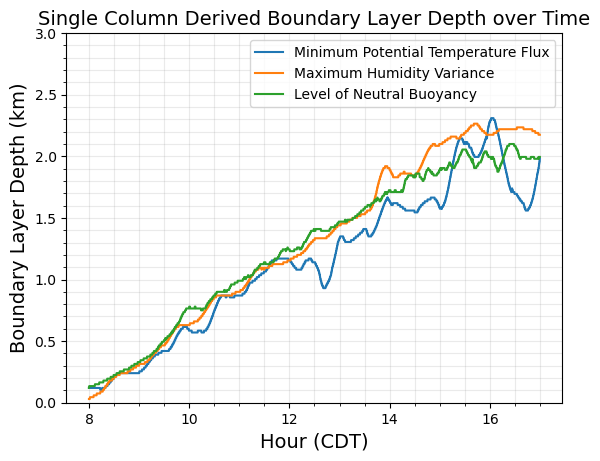

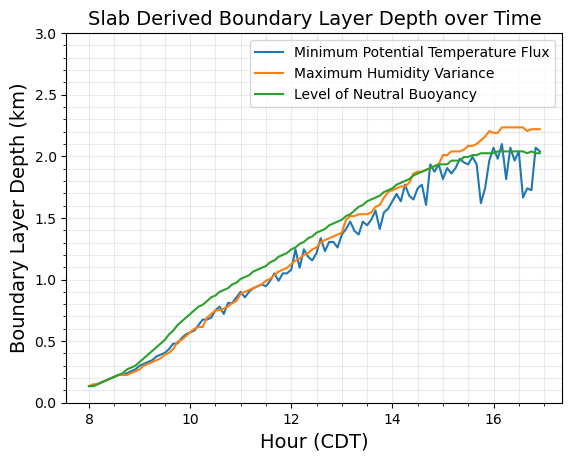

In [10]:
ki_slabmhv = mhv(qt_slab,6,time_slab)
ki_slabmptf = mptf(thlflux_slab,time_slab)
ki_slablnb = lnb(thl_slab)
zislabmhv = zh[ki_slabmhv]
zislabmptf = zh[ki_slabmptf]
zislablnb = zh[ki_slablnb]


# Compare BL depth definitions
kimptf = mptf(thlflux,time)
kimptf = np.round(savgol_filter(kimptf, one_window, order)).astype(int)
kimptf = xr.DataArray(kimptf, coords={'time':time}, dims=['time'])
zimptf = zh[kimptf]

kimhv = mhv(qt, one_window,time)
kimhv = np.round(savgol_filter(kimhv, one_window, order)).astype(int)
kimhv = xr.DataArray(kimhv, coords={'time':time}, dims=['time'])
zimhv = zh[kimhv]

kimlnb = lnb(thl)
kimlnb = np.round(savgol_filter(kimlnb, one_window, order)).astype(int)
kimlnb = xr.DataArray(kimlnb, coords={'time':time}, dims=['time'])
zimlnb = zh[kimlnb]

plt.figure()
plt.plot((time[sr:ss]/3600)+3,(zimptf[sr:ss])/1000, label = 'Minimum Potential Temperature Flux')
plt.plot((time[sr:ss]/3600)+3,(zimhv[sr:ss])/1000, label = 'Maximum Humidity Variance')
plt.plot((time[sr:ss]/3600)+3,(zimlnb[sr:ss])/1000, label = 'Level of Neutral Buoyancy')
#plt.xlim(5,22)
plt.ylim(0,3)
plt.minorticks_on()
plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Hour (CDT)',fontsize = 14)
plt.ylabel('Boundary Layer Depth (km)',fontsize = 14)
plt.title('Single Column Derived Boundary Layer Depth over Time',fontsize=14)
plt.legend()
plt.savefig('/data/OneDrive/Tessa Rosenberger/methodologypaper/'+timeofday+date+'_'+'Boundary_layer_depth_comparison.png')

plt.figure()
plt.plot((time_slab[sr_slab:ss_slab]/3600)+3,(zislabmptf[sr_slab:ss_slab])/1000, label = 'Minimum Potential Temperature Flux')
plt.plot((time_slab[sr_slab:ss_slab]/3600)+3,(zislabmhv[sr_slab:ss_slab])/1000, label = 'Maximum Humidity Variance')
plt.plot((time_slab[sr_slab:ss_slab]/3600)+3,(zislablnb[sr_slab:ss_slab])/1000, label = 'Level of Neutral Buoyancy')
#plt.xlim(5,22)
plt.ylim(0,3)
plt.minorticks_on()
plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Hour (CDT)',fontsize = 14)
plt.ylabel('Boundary Layer Depth (km)',fontsize = 14)
plt.title('Slab Derived Boundary Layer Depth over Time',fontsize = 14)
plt.legend()
plt.savefig('/data/OneDrive/Tessa Rosenberger/methodologypaper/'+timeofday+date+'_'+'Slab_Boundary_layer_depth_comparison.png')



Plot the mixing diagrams for the single column and slab

In [122]:

# CHOOSE A BL DEFINITION 
BL = input('Choose a BL Definition: (1) Minimum Potential Temperature Flux, (2) Maximum Humidity Flux, (3) Maximum Humidity Gradient, (4) Maximum Humidity Variance, (5) Level of Neutral Buoyancy')
if BL == '1':
    # minimum potential temperature flux BL
    BLtype = "Minimum Potential Temperature Flux"
    ki = mptf(thlflux,time)
elif BL == '2':
    # maximum humidity flux BL
    BLtype = "Maximum Humidity Flux"
    ki = mhf(qtflux)
elif BL == '3':
    #maximum humidity gradient BL
    BLtype = "Maximum Humidity Gradient"
    ki = mhg(qt, one_window, order)
elif BL == '4':
    # maximum humidity variance BL
    BLtype = "Maximum Humidity Variance"
    ki = mhv(qt, one_window,time)
elif BL == '5':
    #level of neutral buoyancy BL
    BLtype = "Level of Neutral Buoyancy"
    ki = lnb(thl)



zi = zh[ki]


ki = np.round(savgol_filter(ki, one_window, order)).astype(int)
ki = xr.DataArray(ki, coords={'time':time}, dims=['time'])
zi = zh[ki]
zi = xr.DataArray(zi, coords={'time':time}, dims=['time'])



qt_mean = savgol_filter(mean(qt,ki, time,0,False), one_window, order)
thl_mean = savgol_filter(mean(thl,ki, time,0,False), one_window, order)
qt_adv = advec(qtls,ki,time,dt)
thl_adv = advec(thlls,ki,time,dt)
qt_entr2 = entr2(qt,ki, ki,zi,time, wls, dt,0,False)
thl_entr2 = entr2(thl,ki,ki,zi, time, wls, dt,0,False)




# EXTRAPOLATED SURFACE FLUXES?
SurfaceFlux = input('Extrapolated Surface Fluxes? (1) Yes, (2) No')
if SurfaceFlux == '1':
    Surface = "Extrapolated to Surface"
    qt_surf = surf(qtflux_surfacelayer,0, zi, dt, time)
    thl_surf = surf(thlflux_surfacelayer,0,zi, dt, time)
else:
    # not extrapolated surface fluxes
    Surface = "Not Extrapolated"
    qt_surf = surf(qtflux,ksurf, zi, dt, time)
    thl_surf = surf(thlflux,ksurf,zi, dt, time)



# CHOOSE AVERAGING METHOD FOR ENTRAINMENT FLUXES
Method = input('Choose an Averaging Method for Entrainment Fluxes: (1) Running Average, (2) Normalized by zi')
if Method == '1':
    # Normal Running average entrainment fluxes
    Method = "Running Average"
    qt_entr = entr(qtflux,ki,zi,time,dt, normalized=False)
    thl_entr = entr(thlflux,ki,zi,time,dt, normalized=False) 
elif Method == '2':
    # Normalized by zi running average entrainment fluxes
    Method = "Normalized by zi"
    qt_entrflux = top_flux(qt,w,ki,one_window,dir)
    thl_entrflux = top_flux(thl,w,ki,one_window,dir) 
    qt_entr = entr(qt_entrflux,ki,zi,time,dt,normalized = True)
    thl_entr = entr(thl_entrflux,ki,zi,time,dt, normalized = True)



/tmp/ipykernel_3507059/3299853301.py:41: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_3507059/3299853301.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_3507059/3299853301.py:102: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_3507059/3299853301.py:103: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visib

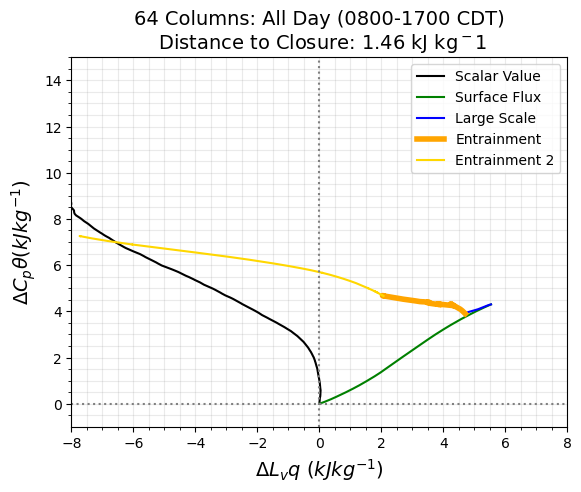

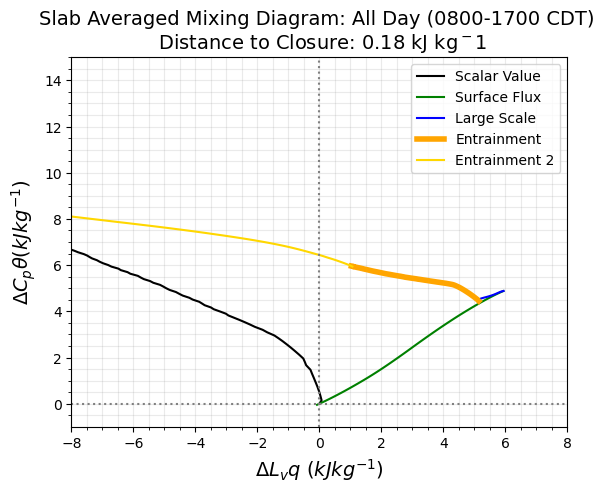

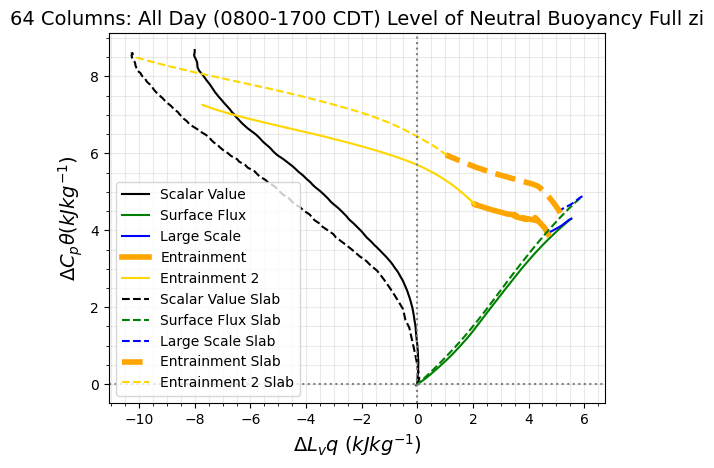

In [123]:

# PLOT MIXING DIAGRAM
plt.figure() 
loc = 0
xarr = qt[sr:ss,loc] - qt[sr,loc]
yarr = thl[sr:ss,loc] - thl[sr,loc]
#plt.plot(xarr,yarr, 'gray', label = str(z[loc].values) +'-m Value')

xarr = qt_mean[sr:ss] - qt_mean[sr]
yarr = thl_mean[sr:ss] -thl_mean[sr]
xval = xarr[-1]
yval = yarr[-1]
plt.plot(xarr,yarr, 'k-', label = 'Scalar Value')

xarr = xarr[0] + add_term(qt_surf,sr,ss,dir)
yarr = yarr[0] + add_term(thl_surf,sr,ss,dir)
plt.plot(xarr,yarr, 'green', label = 'Surface Flux')

xarr = xarr[-1] + add_term(qt_adv,sr,ss,dir)
yarr = yarr[-1] + add_term(thl_adv,sr,ss,dir)
plt.plot(xarr,yarr,'blue', label = 'Large Scale')

xarr = xarr[-1] + add_term(qt_entr,sr,ss,dir)
yarr = yarr[-1] + add_term(thl_entr,sr,ss,dir)
plt.plot(xarr,yarr,'orange', linewidth = 4, label = 'Entrainment')

xarr = xarr[-1] + add_term(qt_entr2,sr,ss,dir)
yarr = yarr[-1] + add_term(thl_entr2,sr,ss,dir)
plt.plot(xarr,yarr,'gold', label = 'Entrainment 2')

thlclos = yval-yarr[-1]
qtclos =xval-xarr[-1]
clos=np.sqrt((qtclos)**2+(thlclos)**2)

plt.title(f"{ColNum}: {timeofday}\n Distance to Closure: {clos.values:.2f} kJ kg$^{-1}$", fontsize=14)
plt.legend()
plt.minorticks_on()
plt.xlim(-8,8)
plt.ylim(-1,15)
plt.axvline(x=0, color='grey', linestyle=':')
plt.axhline(y=0, color='grey', linestyle=':')
plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)    
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)    
plt.xlabel('$\\Delta L_vq$ $(kJ kg^{-1})$',fontsize = 14)
plt.ylabel('$\\Delta C_p \\theta$$ (kJ kg^{-1})$',fontsize = 14)
plt.savefig('/data/OneDrive/Tessa Rosenberger/methodologypaper/'+date+'_'+timeofday+'_'+ColNum+'_MD_'+Method+'_Method_'+Surface+'_'+BLtype+'.png')



# SLAB MIXING DIAGRAM
qt_slab_mean = mean(qt_slab,ki_slab,time_slab,ksurf,False)
thl_slab_mean = mean(thl_slab,ki_slab,time_slab,ksurf,False)
qt_slab_adv = advec(qtls_slab,ki_slab,time_slab,dt_slab)
thl_slab_adv = advec(thlls_slab,ki_slab,time_slab,dt_slab)
qt_slab_entr2 = entr2(qt_slab,ki_slab,ki_slab, zi_slab,time_slab, wls_slab, dt_slab,0,False)
thl_slab_entr2 = entr2(thl_slab,ki_slab,ki_slab,zi_slab, time_slab, wls_slab, dt_slab,0,False)
qt_slab_surf = surf(qtflux_slab,0, zi_slab, dt_slab, time_slab)
thl_slab_surf = surf(thlflux_slab,0,zi_slab, dt_slab, time_slab)
qt_slab_entr = entr(qtflux_slab,ki_slab,zi_slab,time_slab,dt_slab, normalized=False)
thl_slab_entr = entr(thlflux_slab,ki_slab,zi_slab,time_slab,dt_slab, normalized=False)



plt.figure() # plot of everything from surface and estimates and showing 
loc = 0
xarr = qt_slab[sr_slab:ss_slab,loc] - qt_slab[sr_slab,loc]
yarr = thl_slab[sr_slab:ss_slab,loc] - thl_slab[sr_slab,loc]
#plt.plot(xarr,yarr, 'gray', label = str(z[loc].values) +'-m Value')

xarr = qt_slab_mean[sr_slab:ss_slab] - qt_slab_mean[sr_slab]
yarr = thl_slab_mean[sr_slab:ss_slab] -thl_slab_mean[sr_slab]
xval = xarr[-1]
yval = yarr[-1]
plt.plot(xarr,yarr, 'k-', label = 'Scalar Value')

xarr = xarr[0] + add_term(qt_slab_surf,sr_slab,ss_slab,dir)
yarr = yarr[0] + add_term(thl_slab_surf,sr_slab,ss_slab,dir)
plt.plot(xarr,yarr, 'green', label = 'Surface Flux')

xarr = xarr[-1] + add_term(qt_slab_adv,sr_slab,ss_slab,dir)
yarr = yarr[-1] + add_term(thl_slab_adv,sr_slab,ss_slab,dir)
plt.plot(xarr,yarr,'blue', label = 'Large Scale')

xarr = xarr[-1] + add_term(qt_slab_entr,sr_slab,ss_slab,dir)
yarr = yarr[-1] + add_term(thl_slab_entr,sr_slab,ss_slab,dir)
plt.plot(xarr,yarr,'orange', linewidth = 4, label = 'Entrainment')

xarr = xarr[-1] + add_term(qt_slab_entr2,sr_slab,ss_slab,dir)
yarr = yarr[-1] + add_term(thl_slab_entr2,sr_slab,ss_slab,dir)
plt.plot(xarr,yarr,'gold', label = 'Entrainment 2')

thlclos = yval-yarr[-1]
qtclos =xval-xarr[-1]
clos=np.sqrt((qtclos)**2+(thlclos)**2)

plt.title(f'Slab Averaged Mixing Diagram: {timeofday} \n Distance to Closure: {clos.values:.2f} kJ kg$^{-1}$', fontsize=14)
plt.legend()
plt.minorticks_on()
plt.xlim(-8,8)
plt.ylim(-1,15)
plt.axvline(x=0, color='grey', linestyle=':')
plt.axhline(y=0, color='grey', linestyle=':')
plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)    
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)    
plt.xlabel('$\\Delta L_vq$ $(kJ kg^{-1})$',fontsize = 14)
plt.ylabel('$\\Delta C_p \\theta$$ (kJ kg^{-1})$',fontsize = 14)
plt.savefig('/data/OneDrive/Tessa Rosenberger/methodologypaper/'+date+timeofday+'_Slab_MD_'+BLtype+'.png')


# plot the MDs with the slab as lighter lines behind the single column
plt.figure()
loc = 0
xarr = qt[sr:ss,loc] - qt[sr,loc]
yarr = thl[sr:ss,loc] - thl[sr,loc]
#plt.plot(xarr,yarr, 'gray', label = str(z[loc].values) +'-m Value')

xarr = qt_mean[sr:ss] - qt_mean[sr]
yarr = thl_mean[sr:ss] -thl_mean[sr]
xval = xarr[-1]
yval = yarr[-1]
plt.plot(xarr,yarr, 'k-', label = 'Scalar Value')

xarr = xarr[0] + add_term(qt_surf,sr,ss,dir)
yarr = yarr[0] + add_term(thl_surf,sr,ss,dir)
plt.plot(xarr,yarr, 'green', label = 'Surface Flux')

xarr = xarr[-1] + add_term(qt_adv,sr,ss,dir)
yarr = yarr[-1] + add_term(thl_adv,sr,ss,dir)
plt.plot(xarr,yarr,'blue', label = 'Large Scale')

xarr = xarr[-1] + add_term(qt_entr,sr,ss,dir)
yarr = yarr[-1] + add_term(thl_entr,sr,ss,dir)
plt.plot(xarr,yarr,'orange', linewidth = 4, label = 'Entrainment')

xarr = xarr[-1] + add_term(qt_entr2,sr,ss,dir)
yarr = yarr[-1] + add_term(thl_entr2,sr,ss,dir)
plt.plot(xarr,yarr,'gold', label = 'Entrainment 2')

thlclos = yval-yarr[-1]
qtclos =xval-xarr[-1]

xarr = qt_slab[sr_slab:ss_slab,loc] - qt_slab[sr_slab,loc]
yarr = thl_slab[sr_slab:ss_slab,loc] - thl_slab[sr_slab,loc]
#plt.plot(xarr,yarr, 'gray', label = str(z[loc].values) +'-m Value')

xarr = qt_slab_mean[sr_slab:ss_slab] - qt_slab_mean[sr_slab]
yarr = thl_slab_mean[sr_slab:ss_slab] -thl_slab_mean[sr_slab]
xval = xarr[-1]
yval = yarr[-1]
plt.plot(xarr,yarr, 'k--', label = 'Scalar Value Slab')

xarr = xarr[0] + add_term(qt_slab_surf,sr_slab,ss_slab,dir)
yarr = yarr[0] + add_term(thl_slab_surf,sr_slab,ss_slab,dir)
plt.plot(xarr,yarr, 'green', linestyle = '--',label = 'Surface Flux Slab')

xarr = xarr[-1] + add_term(qt_slab_adv,sr_slab,ss_slab,dir)
yarr = yarr[-1] + add_term(thl_slab_adv,sr_slab,ss_slab,dir)
plt.plot(xarr,yarr,'blue', linestyle = '--',label = 'Large Scale Slab')

xarr = xarr[-1] + add_term(qt_slab_entr,sr_slab,ss_slab,dir)
yarr = yarr[-1] + add_term(thl_slab_entr,sr_slab,ss_slab,dir)
plt.plot(xarr,yarr,'orange',  linestyle = '--', linewidth = 4, label = 'Entrainment Slab')

xarr = xarr[-1] + add_term(qt_slab_entr2,sr_slab,ss_slab,dir)
yarr = yarr[-1] + add_term(thl_slab_entr2,sr_slab,ss_slab,dir)
plt.plot(xarr,yarr,'gold', linestyle = '--', label = 'Entrainment 2 Slab')

plt.title(f"{ColNum}: {timeofday} {BLtype} Full zi", fontsize=14)
plt.legend()
plt.minorticks_on()
#plt.xlim(-8,8)
#plt.ylim(-1,15)
plt.axvline(x=0, color='grey', linestyle=':')
plt.axhline(y=0, color='grey', linestyle=':')
plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('$\\Delta L_vq$ $(kJ kg^{-1})$',fontsize = 14)
plt.ylabel('$\\Delta C_p \\theta$$ (kJ kg^{-1})$',fontsize = 14)
plt.savefig('/data/OneDrive/Tessa Rosenberger/methodologypaper/'+date+'_'+timeofday+'_'+ColNum+'_MD_'+Method+'_Method_'+Surface+'_'+BLtype+'_Slab.png')

/tmp/ipykernel_3507059/818691786.py:138: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_3507059/818691786.py:139: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)


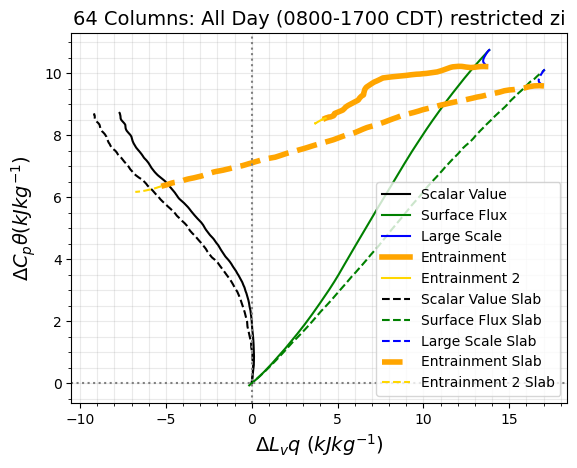

In [73]:
# make the same MD with both slab and single column but use 0.1zi to 0.5zi
zi_slab1 = np.round(0.1*zi_slab)
zi_slab2 = np.round(0.5*zi_slab)
zi_slab2 = zi_slab2 - zi_slab1

ki_slab1 = np.zeros_like(zi_slab1, dtype=int)
for i, val in enumerate(zi_slab1):
    closest_index = np.abs(zh - val).argmin()
    ki_slab1[i] = closest_index

ki_slab2 = np.zeros_like(zi_slab2, dtype=int)
for i, val in enumerate(zi_slab2):
    closest_index = np.abs(zh - val).argmin()
    ki_slab2[i] = closest_index

time = prof_all['time']
time_slab = prof_slab['time']

# Create DataArrays with the custom time definitions
ki_slab1 = xr.DataArray(ki_slab1, coords={'time': time_slab}, dims=['time'])
ki_slab2 = xr.DataArray(ki_slab2, coords={'time': time_slab}, dims=['time'])
kidiffslab = ki_slab2 - ki_slab1


zi_1 = np.round(0.1*zi)
zi_2 = np.round(0.5*zi)
zi_2 = zi_2 - zi_1

ki_1 = np.zeros_like(zi_1, dtype=int)
for i, val in enumerate(zi_1):
    closest_index = np.abs(zh - val).argmin()
    ki_1[i] = closest_index

ki_2 = np.zeros_like(zi_2, dtype=int)
for i, val in enumerate(zi_2):
    closest_index = np.abs(zh - val).argmin()
    ki_2[i] = closest_index

# Create DataArrays with the custom time definitions
ki_1 = xr.DataArray(ki_1, coords={'time': time}, dims=['time'])
ki_2 = xr.DataArray(ki_2, coords={'time': time}, dims=['time'])


qt_mean = savgol_filter(mean(qt,ki_2, time,ki_1,True), one_window, order)
thl_mean = savgol_filter(mean(thl,ki_2, time,ki_1,True), one_window, order)
qt_adv = advec(qtls,ki_2,time,dt)
thl_adv = advec(thlls,ki_2,time,dt)
qt_entr2 = entr2(qt,ki_2, ki_2,zi_2,time, wls, dt,ki_1,True)
thl_entr2 = entr2(thl,ki_2,ki_2,zi_2, time, wls, dt,ki_1,True)

# extrapolated surface fluxes    
qt_surf = surf(qtflux_surfacelayer,0, zi_2, dt, time)
thl_surf = surf(thlflux_surfacelayer,0,zi_2, dt, time)

qt_entrflux = top_flux(qt,w,ki_2,one_window,dir)
thl_entrflux = top_flux(thl,w,ki_2,one_window,dir) 
qt_entr = entr(qtflux,ki_2,zi_2,time,dt,normalized = False)
thl_entr = entr(thlflux,ki_2,zi_2,time,dt, normalized = False)


#slab 
qt_slab_mean = mean(qt_slab,ki_slab2,time_slab,ki_slab1,True)
thl_slab_mean = mean(thl_slab,ki_slab2,time_slab,ki_slab1,True)
qt_slab_adv = advec(qtls_slab,ki_slab2,time_slab,dt_slab)
thl_slab_adv = advec(thlls_slab,ki_slab2,time_slab,dt_slab)
qt_slab_entr2 = entr2(qt_slab,ki_slab2,ki_slab2, zi_slab2,time_slab, wls_slab, dt_slab,ki_slab1,True)
thl_slab_entr2 = entr2(thl_slab,ki_slab2,ki_slab2,zi_slab2, time_slab, wls_slab, dt_slab,ki_slab1,True)
qt_slab_surf = surf(qtflux_slab,ki_slab1, zi_slab2, dt_slab, time_slab)
thl_slab_surf = surf(thlflux_slab,ki_slab1,zi_slab2, dt_slab, time_slab)
qt_slab_entr = entr(qtflux_slab,ki_slab2,zi_slab2,time_slab,dt_slab, normalized=False)
thl_slab_entr = entr(thlflux_slab,ki_slab2,zi_slab2,time_slab,dt_slab, normalized=False)


plt.figure()
loc = 0
xarr = qt[sr:ss,loc] - qt[sr,loc]
yarr = thl[sr:ss,loc] - thl[sr,loc]
#plt.plot(xarr,yarr, 'gray', label = str(z[loc].values) +'-m Value')

xarr = qt_mean[sr:ss] - qt_mean[sr]
yarr = thl_mean[sr:ss] -thl_mean[sr]
xval = xarr[-1]
yval = yarr[-1]
plt.plot(xarr,yarr, 'k-', label = 'Scalar Value')

xarr = xarr[0] + add_term(qt_surf,sr,ss,dir)
yarr = yarr[0] + add_term(thl_surf,sr,ss,dir)
plt.plot(xarr,yarr, 'green', label = 'Surface Flux')

xarr = xarr[-1] + add_term(qt_adv,sr,ss,dir)
yarr = yarr[-1] + add_term(thl_adv,sr,ss,dir)
plt.plot(xarr,yarr,'blue', label = 'Large Scale')

xarr = xarr[-1] + add_term(qt_entr,sr,ss,dir)
yarr = yarr[-1] + add_term(thl_entr,sr,ss,dir)
plt.plot(xarr,yarr,'orange', linewidth = 4, label = 'Entrainment')

xarr = xarr[-1] + add_term(qt_entr2,sr,ss,dir)
yarr = yarr[-1] + add_term(thl_entr2,sr,ss,dir)
plt.plot(xarr,yarr,'gold', label = 'Entrainment 2')

thlclos = yval-yarr[-1]
qtclos =xval-xarr[-1]

xarr = qt_slab[sr_slab:ss_slab,loc] - qt_slab[sr_slab,loc]
yarr = thl_slab[sr_slab:ss_slab,loc] - thl_slab[sr_slab,loc]
#plt.plot(xarr,yarr, 'gray', label = str(z[loc].values) +'-m Value')

xarr = qt_slab_mean[sr_slab:ss_slab] - qt_slab_mean[sr_slab]
yarr = thl_slab_mean[sr_slab:ss_slab] -thl_slab_mean[sr_slab]
xval = xarr[-1]
yval = yarr[-1]
plt.plot(xarr,yarr, 'k--', label = 'Scalar Value Slab')

xarr = xarr[0] + add_term(qt_slab_surf,sr_slab,ss_slab,dir)
yarr = yarr[0] + add_term(thl_slab_surf,sr_slab,ss_slab,dir)
plt.plot(xarr,yarr, 'green', linestyle = '--',label = 'Surface Flux Slab')

xarr = xarr[-1] + add_term(qt_slab_adv,sr_slab,ss_slab,dir)
yarr = yarr[-1] + add_term(thl_slab_adv,sr_slab,ss_slab,dir)
plt.plot(xarr,yarr,'blue', linestyle = '--',label = 'Large Scale Slab')

xarr = xarr[-1] + add_term(qt_slab_entr,sr_slab,ss_slab,dir)
yarr = yarr[-1] + add_term(thl_slab_entr,sr_slab,ss_slab,dir)
plt.plot(xarr,yarr,'orange',  linestyle = '--', linewidth = 4, label = 'Entrainment Slab')

xarr = xarr[-1] + add_term(qt_slab_entr2,sr_slab,ss_slab,dir)
yarr = yarr[-1] + add_term(thl_slab_entr2,sr_slab,ss_slab,dir)
plt.plot(xarr,yarr,'gold', linestyle = '--', label = 'Entrainment 2 Slab')

plt.title(f"{ColNum}: {timeofday} restricted zi", fontsize=14)
plt.legend()
plt.minorticks_on()
#plt.xlim(-8,8)
#plt.ylim(-1,15)
plt.axvline(x=0, color='grey', linestyle=':')
plt.axhline(y=0, color='grey', linestyle=':')
plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('$\\Delta L_vq$ $(kJ kg^{-1})$',fontsize = 14)
plt.ylabel('$\\Delta C_p \\theta$$ (kJ kg^{-1})$',fontsize = 14)
plt.savefig('/data/OneDrive/Tessa Rosenberger/methodologypaper/'+date+'_'+timeofday+'_'+ColNum+'_MD_'+Method+'_Method_'+Surface+'_'+BLtype+'_Slab.png')


e2 definition scatter plot

In [ ]:
#%% E1 AND E2 SCATTER - the estimated zi vs zi for calculating E2
# e1 average from each column
zi_slab1 = np.round(0.1*zi_slab)
zi_slab2 = np.round(0.5*zi_slab)

ki_slab1 = np.zeros_like(zi_slab1, dtype=int)
for i, val in enumerate(zi_slab1):
    closest_index = np.abs(zh - val).argmin()
    ki_slab1[i] = closest_index

ki_slab2 = np.zeros_like(zi_slab2, dtype=int)
for i, val in enumerate(zi_slab2):
    closest_index = np.abs(zh - val).argmin()
    ki_slab2[i] = closest_index

time = prof_all['time']
time_slab = prof_slab['time']

# Create DataArrays with the custom time definitions
ki_slab1 = xr.DataArray(ki_slab1, coords={'time': time_slab}, dims=['time'])
ki_slab2 = xr.DataArray(ki_slab2, coords={'time': time_slab}, dims=['time'])
kidiffslab = ki_slab2 - ki_slab1

print(time.dims)

zi_1 = np.round(0.1*zi)
zi_2 = np.round(0.5*zi)

ki_1 = np.zeros_like(zi_1, dtype=int)
for i, val in enumerate(zi_1):
    closest_index = np.abs(zh - val).argmin()
    ki_1[i] = closest_index

ki_2 = np.zeros_like(zi_2, dtype=int)
for i, val in enumerate(zi_2):
    closest_index = np.abs(zh - val).argmin()
    ki_2[i] = closest_index

# Create DataArrays with the custom time definitions
ki_1 = xr.DataArray(ki_1, coords={'time': time}, dims=['time'])
ki_2 = xr.DataArray(ki_2, coords={'time': time}, dims=['time'])
kidiff = ki_2 - ki_1


#%%
qt_entr_avg = np.zeros((filenames.size))
thl_entr_avg = np.zeros((filenames.size))
qt_entr_avgzi = np.zeros((filenames.size))
thl_entr_avgzi = np.zeros((filenames.size))
thl_entr2_scatter = np.zeros((filenames.size))
qt_entr2_scatter = np.zeros((filenames.size))
qt_entr2est = np.zeros((filenames.size))
thl_entr2est = np.zeros((filenames.size))
x = np.arange(0,8,1)
y = np.arange(0,8,1)

for i in range(x.size):
    for j in range(y.size):
        thl_scatter = get_data(i,j,'thl',dir)#get_data(dir, filenames[i],z_idx, 'thl')
        qt_scatter = get_data(i,j,'qt',dir)#get_data(dir, filenames[i], z_idx,'qt')
        wh_scatter = get_data(i,j,'w',dir)#get_data(dir, filenames[i], zh_idx,'w')
        thl_scatter = thl_scatter*cp
        qt_scatter = np.multiply(qt_scatter*Lv, 1)
        w_scatter = wh_scatter.interp(time = time, zh = z) #take the vertical velocity at z instead of zh
        thlflux_scatter = flux(thl_scatter, w_scatter,one_window,dir)
        qtflux_scatter = flux(qt_scatter, w_scatter,one_window,dir)
        qt_entr_scatter = entr(qtflux_scatter,ki,zi,time,dt, normalized=False)
        # thl_entr_scatter = entr(thlflux_scatter,ki,zi,time,dt, normalized=False) 
        # qt_entr_scatter_sum = add_term(qt_entr_scatter,sr,ss,dir)
        # thl_entr_scatter_sum = add_term(thl_entr_scatter,sr,ss,dir)
        index = i*y.size + j
        # qt_entr_avg[index] = qt_entr_scatter_sum[-1]
        # thl_entr_avg[index] = thl_entr_scatter_sum[-1]
        # qt_entrflux = top_flux(qt_scatter,w_scatter,ki,one_window,dir)
        # thl_entrflux = top_flux(thl_scatter,w_scatter,ki,one_window,dir) 
        # qt_entr = entr(qt_entrflux,ki,zi,time,dt,normalized = True)
        # thl_entr = entr(thl_entrflux,ki,zi,time,dt, normalized = True)
        # qt_entr_sum = add_term(qt_entr,sr,ss,dir)
        # thl_entr_sum = add_term(thl_entr,sr,ss,dir)
        # qt_entr_avgzi[index] = qt_entr_sum[-1]
        # thl_entr_avgzi[index] = thl_entr_sum[-1]
        qt_entr2 = entr2(qt_scatter,ki,ki, zi,time, wls, dt,0,False)
        thl_entr2 = entr2(thl_scatter,ki,ki,zi, time, wls, dt,0,False)
        qtentr2est = entr2(qt_scatter,ki,ki_2,zi_2,time,wls,dt,ki_1,True)
        thlentr2est = entr2(thl_scatter,ki,ki_2,zi_2,time,wls,dt,ki_1,True)
        qtentr2estsum = add_term(qtentr2est,sr,ss,dir)
        thlentr2estsum = add_term(thlentr2est,sr,ss,dir)
        qt_entr2est[index] = qtentr2estsum[-1] - qtentr2estsum[0]
        thl_entr2est[index] = thlentr2estsum[-1] - thlentr2estsum[0]
        qt_entr2_sum = add_term(qt_entr2,sr,ss,dir)
        thl_entr2_sum = add_term(thl_entr2,sr,ss,dir)
        qt_entr2_scatter[index] = qt_entr2_sum[-1] - qt_entr2_sum[0]
        thl_entr2_scatter[index] = thl_entr2_sum[-1] - thl_entr2_sum[0]


# qt_slab_entr_sum = add_term(qt_slab_entr,sr_slab,ss_slab,dir)
# thl_slab_entr_sum = add_term(thl_slab_entr,sr_slab,ss_slab,dir)
# qt_slab_entr1 = qt_slab_entr_sum[-1] - qt_slab_entr_sum[0]
# thl_slab_entr1 = thl_slab_entr_sum[-1] - thl_slab_entr_sum[0]
qt_slab_entr2 = entr2(qt_slab,ki_slab,ki_slab, zi_slab,time_slab, wls_slab, dt_slab,0,False)
thl_slab_entr2 = entr2(thl_slab,ki_slab,ki_slab,zi_slab, time_slab, wls_slab, dt_slab,0,False)
qt_slab_entr2_sum = add_term(qt_slab_entr2,sr_slab,ss_slab,dir)
thl_slab_entr2_sum = add_term(thl_slab_entr2,sr_slab,ss_slab,dir)
qt_slab_entr_2 = qt_slab_entr2_sum[-1] - qt_slab_entr2_sum[0]
thl_slab_entr_2 = thl_slab_entr2_sum[-1] - thl_slab_entr2_sum[0]

qt_slab_entr2est = entr2(qt_slab,ki_slab,ki_slab2, zi_slab,time_slab, wls_slab, dt_slab,ki_slab1,True)
thl_slab_entr2est = entr2(thl_slab,ki_slab,ki_slab2,zi_slab, time_slab, wls_slab, dt_slab,ki_slab1,True)
qt_slab_entr2estsum = add_term(qt_slab_entr2est,sr_slab,ss_slab,dir)
thl_slab_entr2estsum = add_term(thl_slab_entr2est,sr_slab,ss_slab,dir)
qt_slab_entr2_est = qt_slab_entr2estsum[-1] - qt_slab_entr2estsum[0]
thl_slab_entr2_est = thl_slab_entr2estsum[-1] - thl_slab_entr2estsum[0]


# plt.figure()
# plt.plot(qt_entr_avg, thl_entr_avg, 'o', color = 'gray', label = 'Each Column')
# plt.plot(qt_slab_entr1, thl_slab_entr1, 'o',color = 'blue', label = 'Slab')
# plt.legend()
# plt.title(date +timeofday+' E1 Scatter Average')
# plt.minorticks_on()
# plt.ylabel('E1 of $\Theta_l$')
# plt.xlabel('E1 of $q_t$')
# plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
# plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
# plt.savefig('/data/OneDrive/Tessa Rosenberger/methodologypaper/'+date+'_'+timeofday+'_E1_scatter.png')


# # e1 Normalized by zi
# plt.figure()
# plt.plot(qt_entr_avgzi, thl_entr_avgzi, 'o', color = 'gray', label = 'Each Column')
# plt.plot(qt_slab_entr1, thl_slab_entr1, 'o',color = 'blue', label = 'Slab')
# plt.legend()
# plt.title(date +timeofday+' E1 Scatter Normalized by zi')
# plt.minorticks_on()
# plt.ylabel('E1 of $\Theta_l$')
# plt.xlabel('E1 of $q_t$')
# plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
# plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
# plt.savefig('/data/OneDrive/Tessa Rosenberger/methodologypaper/'+date+'_'+timeofday+'_E1_scatter_avgzi.png')


# e2 from each column
plt.figure()
plt.plot(qt_entr2_scatter, thl_entr2_scatter, 'o', color = 'gray', label = 'Full zi')
plt.plot(qt_entr2est, thl_entr2est, '+',color = 'orange', markeredgewidth = 2, label = '0.1 zi - 0.5 zi')
plt.plot(qt_slab_entr_2, thl_slab_entr_2, 'o',color = 'blue', label = 'Slab with Full zi')
plt.plot(qt_slab_entr2_est, thl_slab_entr2_est, '+',color = 'blue', markeredgewidth = 2, label = 'Slab with 0.1 zi - 0.5 zi')
plt.legend()
plt.title(timeofday+' ENT2 Scatter', fontsize = 14)
plt.minorticks_on()
plt.ylabel('ENT2 of $\\Delta C_p \\Theta_l (kJ kg^{-1})$', fontsize = 14)
plt.xlabel('ENT2 of $\\Delta L_v  q_t (kJ kg^{-1})$', fontsize = 14)
#plt.xlim(-10,-6)
plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.savefig('/data/OneDrive/Tessa Rosenberger/methodologypaper/'+date+'_'+timeofday+'_E2_scatter.png')

Closure vs closure scatter plots across 5 dates and on a single date

In [11]:
BLtype = 'Level of Neutral Buoyancy'
Method = 'Normalized by zi'
Surface = 'Extrapolated to Surface'
ColNum = 'Sum of Columns'
dir07 = '/data/lafe/20170807/through_evening/'
dir14 = '/data/lafe/20170814/through_evening/'
dir17 = '/data/lafe/20170817/through_evening/'
dir29 = '/data/lafe/20170829/through_evening/'
list_of_directories = [dir07,dir, dir14, dir17, dir29]



In [44]:

x= np.arange(0,8,1)
y= np.arange(0,8,1)

thl_clos_slab07 = closure(x_file,x,y,dir07,one_window, 'Slab',BLtype, Method, Surface,ksurf,order )[0]
qt_clos_slab07 = closure(x_file,x,y,dir07,one_window, 'Slab',BLtype, Method, Surface,ksurf,order )[1]
qt_clos_slab08 = closure(x_file,x,y,dir,one_window, 'Slab',BLtype, Method, Surface,ksurf,order )[1]
thl_clos_slab08 = closure(x_file,x,y,dir,one_window, 'Slab',BLtype, Method, Surface,ksurf,order )[0]
qt_clos_slab14 = closure(x_file,x,y,dir14,one_window, 'Slab',BLtype, Method, Surface,ksurf,order )[1]
thl_clos_slab14 = closure(x_file,x,y,dir14,one_window, 'Slab',BLtype, Method, Surface,ksurf,order )[0]
qt_clos_slab17 = closure(x_file,x,y,dir17,one_window, 'Slab',BLtype, Method, Surface,ksurf,order )[1]
thl_clos_slab17 = closure(x_file,x,y,dir17,one_window, 'Slab',BLtype, Method, Surface,ksurf,order )[0]
qt_clos_slab29 = closure(x_file,x,y,dir29,one_window, 'Slab',BLtype, Method, Surface,ksurf,order )[1]
thl_clos_slab29 = closure(x_file,x,y,dir29,one_window, 'Slab',BLtype, Method, Surface,ksurf,order )[0]


plt.figure()
pairs = list(product(x, repeat=2)) # all possible pairs of the column coordinates
thl_clos07 = np.zeros((filenames.size))
qt_clos07 = np.zeros((filenames.size))
thl_clos08 = np.zeros((filenames.size))
qt_clos08 = np.zeros((filenames.size))
thl_clos14 = np.zeros((filenames.size))
qt_clos14 = np.zeros((filenames.size))
thl_clos17 = np.zeros((filenames.size))
qt_clos17 = np.zeros((filenames.size))
thl_clos29 = np.zeros((filenames.size))
qt_clos29 = np.zeros((filenames.size))
for i in range(len(pairs)):
    thl_clos07[i] = closure(x_file,int(pairs[i][0]),int(pairs[i][1]), dir07, one_window,'Individual Column', BLtype, Method, Surface, ksurf, order )[0]
    qt_clos07[i] = closure(x_file,int(pairs[i][0]),int(pairs[i][1]), dir07, one_window, 'Individual Column',BLtype, Method, Surface, ksurf, order )[1]
    thl_clos08[i] = closure(x_file,int(pairs[i][0]),int(pairs[i][1]), dir, one_window,'Individual Column', BLtype, Method, Surface, ksurf, order )[0]
    qt_clos08[i] = closure(x_file,int(pairs[i][0]),int(pairs[i][1]), dir, one_window, 'Individual Column',BLtype, Method, Surface, ksurf, order )[1]
    thl_clos14[i] = closure(x_file,int(pairs[i][0]),int(pairs[i][1]), dir14, one_window,'Individual Column', BLtype, Method, Surface, ksurf, order )[0]
    qt_clos14[i] = closure(x_file,int(pairs[i][0]),int(pairs[i][1]), dir14, one_window, 'Individual Column',BLtype, Method, Surface, ksurf, order )[1]
    thl_clos17[i] = closure(x_file,int(pairs[i][0]),int(pairs[i][1]), dir17, one_window,'Individual Column', BLtype, Method, Surface, ksurf, order )[0]
    qt_clos17[i] = closure(x_file,int(pairs[i][0]),int(pairs[i][1]), dir17, one_window, 'Individual Column',BLtype, Method, Surface, ksurf, order )[1]
    thl_clos29[i] = closure(x_file,int(pairs[i][0]),int(pairs[i][1]), dir29, one_window,'Individual Column', BLtype, Method, Surface, ksurf, order )[0]
    qt_clos29[i] = closure(x_file,int(pairs[i][0]),int(pairs[i][1]), dir29, one_window, 'Individual Column',BLtype, Method, Surface, ksurf, order )[1]
thl_colsmean07 = np.mean(thl_clos07)
thl_cols07std = np.std(thl_clos07)
qt_colsmean07 = np.mean(qt_clos07)
qt_cols07std = np.std(qt_clos07)
thl_colsmean08 = np.mean(thl_clos08)
thl_cols08std = np.std(thl_clos08)
qt_colsmean08 = np.mean(qt_clos08)
qt_cols08std = np.std(qt_clos08)
thl_colsmean14 = np.mean(thl_clos14)
thl_cols14std = np.std(thl_clos14)
qt_colsmean14 = np.mean(qt_clos14)
qt_cols14std = np.std(qt_clos14)
thl_colsmean17 = np.mean(thl_clos17)
thl_cols17std = np.std(thl_clos17)
qt_colsmean17 = np.mean(qt_clos17)
qt_cols17std = np.std(qt_clos17)
thl_colsmean29 = np.mean(thl_clos29)
thl_cols29std = np.std(thl_clos29)
qt_colsmean29 = np.mean(qt_clos29)
qt_cols29std = np.std(qt_clos29)
#plot the mean values for each date along with the associated 1 sigma error
plt.errorbar(qt_colsmean07,thl_colsmean07, xerr = qt_cols07std, yerr = thl_cols07std, fmt = '+', markeredgewidth = 3, elinewidth = 1, color = 'purple', label = 'Average of all Columns')
plt.errorbar(qt_colsmean08,thl_colsmean08, xerr = qt_cols08std, yerr = thl_cols08std, fmt = '+', markeredgewidth = 3, elinewidth = 1, color = 'purple')
plt.errorbar(qt_colsmean14,thl_colsmean14, xerr = qt_cols14std, yerr = thl_cols14std, fmt = '+', markeredgewidth = 3, elinewidth = 1, color = 'purple')
plt.errorbar(qt_colsmean17,thl_colsmean17, xerr = qt_cols17std, yerr = thl_cols17std, fmt = '+', markeredgewidth = 3, elinewidth = 1, color = 'purple')
plt.errorbar(qt_colsmean29,thl_colsmean29, xerr = qt_cols29std, yerr = thl_cols29std, fmt = '+', markeredgewidth = 3, elinewidth = 1, color = 'purple')
plt.plot(qt_colsmean07,thl_colsmean07, '+',markeredgewidth = 2, color = 'purple')
plt.plot(qt_colsmean08,thl_colsmean08, '+',markeredgewidth = 2, color = 'purple')
plt.plot(qt_colsmean14,thl_colsmean14, '+',markeredgewidth = 2, color = 'purple')
plt.plot(qt_colsmean17,thl_colsmean17, '+',markeredgewidth = 2, color = 'purple')
plt.plot(qt_colsmean29,thl_colsmean29, '+',markeredgewidth = 2, color = 'purple')
plt.plot(qt_clos_slab07, thl_clos_slab07, 'bo', label = 'Slab')
plt.plot(qt_clos_slab08, thl_clos_slab08, 'bo')
plt.plot(qt_clos_slab14, thl_clos_slab14, 'bo')
plt.plot(qt_clos_slab17, thl_clos_slab17, 'bo')
plt.plot(qt_clos_slab29, thl_clos_slab29, 'bo')
plt.legend()
plt.minorticks_on()
plt.xlim(-5,4)
plt.ylim(-1,4)
plt.xlabel('Closure of $\\Delta L_vq$ $(kJ kg^{-1})$', fontsize = 14)
plt.ylabel('Closure of $\\Delta C_p \\theta$$ (kJ kg^{-1})$', fontsize = 14)
plt.axvline(x=0, color='grey', linestyle=':')
plt.axhline(y=0, color='grey', linestyle=':')
plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)    
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.title(' Closure of $\\Delta C_p \\theta$$ (kJ kg^{-1})$ vs. $\\Delta L_vq$ $(kJ kg^{-1})$:' +timeofday, fontsize = 14)
plt.savefig(outdir+timeofday+'_Scatter_Compare_Closures_all_days'+Method+'_Method_'+Surface+'_'+BLtype+'.png', bbox_inches='tight')





qtclos= closure(x_file,np.arange(0,8),np.arange(0,8),dir,one_window,'Sum of Columns',BLtype, Method, Surface, ksurf, order)[1]
thlclos = closure(x_file,np.arange(0,8),np.arange(0,8),dir,one_window,'Sum of Columns',BLtype, Method, Surface, ksurf, order)[0]
plt.figure()
pairs = list(product(x, repeat=2)) # all possible pairs of the column coordinates
thl_clos08 = np.zeros((filenames.size))
qt_clos08 = np.zeros((filenames.size))
for i in range(len(pairs)):
    thl_clos08[i] = closure(x_file,int(pairs[i][0]),int(pairs[i][1]), dir, one_window,'Individual Column', BLtype, Method, Surface, ksurf, order )[0]
    qt_clos08[i] = closure(x_file,int(pairs[i][0]),int(pairs[i][1]), dir, one_window, 'Individual Column',BLtype, Method, Surface, ksurf, order )[1]
thl_colsmean08 = np.mean(thl_clos08)
qt_colsmean08 = np.mean(qt_clos08)
plt.plot(qt_clos08, thl_clos08, 'o', color = 'darkgrey', label = 'Each Column')
plt.plot(qt_colsmean08,thl_colsmean08, '+',markeredgewidth = 2, color = 'purple',label = "Average of all Columns")
plt.plot(qtclos, thlclos, 'o',color = 'orange', label = ColNum)
#plt.plot(qt_clos_slab07, thl_clos_slab07, 'bo', label = 'Slab7')
plt.plot(qt_clos_slab08, thl_clos_slab08, 'bo', label = 'Slab')
plt.legend()
plt.minorticks_on()
plt.xlim(-7,5)
plt.ylim(-7,5)
plt.xlabel('Closure of $\\Delta L_vq$ $(kJ kg^{-1})$', fontsize = 14)
plt.ylabel('Closure of $\\Delta C_p \\theta$$ (kJ kg^{-1})$', fontsize = 14)
plt.axvline(x=0, color='grey', linestyle=':')
plt.axhline(y=0, color='grey', linestyle=':')
plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)    
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.title(' Closure of $\\Delta C_p \\theta$$ (kJ kg^{-1})$ vs. $\\Delta L_vq$ $(kJ kg^{-1})$: ' +timeofday, fontsize = 14)
plt.savefig(outdir+date+timeofday+'_Scatter_Compare_Closures'+Method+'_Method_'+Surface+'_'+BLtype+'.png', bbox_inches='tight')


TypeError: closure() missing 3 required positional arguments: 'time_idx', 'z_idx', and 'zh_idx'

ratio of total entrainment 

In [ ]:
# THE RATIO OF E1/(E1+E2) FOR EACH DATE (DIFFERENT COLOR) AND FOR EACH OF THE 3 BLDEPTH DEFINITIONS
# make a scatter plot of thl e1/(e1+e2) vs qt e1/(e1+e2)

def slabmhv(prof_slab):
    qt_var = prof_slab['qt_2']
    ki = qt_var.argmax(axis = 1)
    return ki

def mptf(temperature_flux, time): # minumum potential temperature flux BL definition (thlflux)
    ki = temperature_flux.argmin(axis = 1).to_numpy()
    # make sure the indicies of zi are within the correct range
    for i in range(time.size):
        if ki[i] > len(time):
            ki[i] = len(time) - 1
        else:
            ki[i] = ki[i]
    return ki
#%%
list_of_directories = [dir07, dir, dir14, dir17, dir29]
list_of_bltypes = ['Maximum Humidity Variance', 'Level of Neutral Buoyancy', 'Minimum Potential Temperature Flux']
filenames_slab = 'testbed.default.0000000.nc'

dates = ['20170807', '20170808','20170814', '20170817', '20170829']


# Dictionary to hold the ratios
ratios = {'Date': [], 'BLType': [], 'thl_ratio': [], 'qt_ratio': []}

# Loop over each directory and BL type
for i in range(len(list_of_directories)):
    for bltype in list_of_bltypes:
        # Load data - adapt this according to how your files are stored/named
        groups_slab = [''] + list(nc.Dataset(list_of_directories[i] + filenames_slab).groups.keys())
        prof_dict_slab = {}
        for group in groups_slab:
            prof_dict_slab[group] = xr.open_dataset(list_of_directories[i] + filenames_slab, group=group, decode_times=False)
            ds = xr.merge(prof_dict_slab.values(), compat = 'override')

        # Get profiles for the current directory and BL type, pseudo-code here
        thl_flux = ds['thl_flux'] * cp
        qt_flux = ds['qt_flux'] * Lv
        thl = ds['thl']*cp
        qt = ds['qt']*Lv
        w = ds['w'].interp(time = ds['time'], zh = ds['zh'])
        time = ds['time']
        dt = time.diff('time')[0].to_numpy()
        sr = int((abs(time - start)).argmin())
        ss = int((abs(time - end)).argmin())

        # Compute indices or levels specific to each BL type, pseudo-code functions
        ki = None  # Default initialization
        if bltype == "Minimum Potential Temperature Flux":
            ki = mptf(thl_flux, ds['time'])
        elif bltype == "Maximum Humidity Variance":  # Corrected the condition here
            ki = slabmhv(ds)
        elif bltype == "Level of Neutral Buoyancy":
            ki = lnb(thl)
        else:
            print(f"Unknown BL type {bltype}, skipping...")
        if ki is None:
            print(f"Index 'ki' not set for BL type {bltype}, skipping...")
        ki = xr.DataArray(ki, coords={'time':time}, dims=['time'])
        zi = ds['zh'][ki]  # Height at index ki

        # Compute entrainment using a function entr(), needs to be defined or adapted
        thl_ent = entr(thl_flux, ki, zi, time,dt,normalized=False)
        qt_ent = entr(qt_flux, ki, zi, ds['time'],dt,normalized=False)
        thlent2 = entr2(thl,ki,ki,zi,ds['time'],w,dt,0,entrzone = False)
        qtent2 = entr2(qt,ki,ki,zi,ds['time'],w,dt,0,entrzone = False)
        qtent1 = 0 + add_term(qt_ent,sr,ss,list_of_directories[i])
        thlent1 = 0 + add_term(thl_ent,sr,ss,list_of_directories[i])
        qt_ent2 = qtent1[-1] + add_term(qtent2,sr,ss,list_of_directories[i])
        thl_ent2 = thlent1[-1] + add_term(thlent2,sr,ss,list_of_directories[i])
        # Compute ratios - Assuming this is where you calculate ratios based on your methodology
        thl_ratio = thlent1[-1]/thl_ent2[-1]  # Define calculate_ratio
        qt_ratio = qtent1[-1]/qt_ent2[-1]  # Define calculate_ratio

        # Store results
        ratios['Date'].append(dates[i])
        ratios['BLType'].append(bltype)
        ratios['thl_ratio'].append(thl_ratio)
        ratios['qt_ratio'].append(qt_ratio)

# Convert to DataFrame
df = pd.DataFrame(ratios)

# Now df holds all the computed ratios and can be used for plotting or analysis
print(df)

markers = ['o', '^', 's', 'p', 'h']  # Assume 5 different dates, corresponding to 5 directories
colors = ['orange', 'green', 'lightblue']  # 3 different BLTypes

# Mapping directories to markers and BLTypes to colors
date_marker = {dir_name: marker for dir_name, marker in zip(df['Date'].unique(), markers)}
bltype_color = {bl_type: color for bl_type, color in zip(df['BLType'].unique(), colors)}

# Create the scatter plot
plt.figure(figsize=(10, 6))
for (dir_name, bl_type), group in df.groupby(['Date', 'BLType']):
    plt.scatter(group['qt_ratio'], group['thl_ratio'], color=bltype_color[bl_type],
                marker=date_marker[dir_name], label=f'{bl_type} ({dir_name})', s=200)

plt.xlim(0.1,0.9)
plt.ylim(0,1.1)
# Set titles and labels
plt.title(f'Scatter Plot of Mean ENT1/(ENT1+ENT2) Ratios - {timeofday}', fontsize=14)
plt.xlabel('$\\Delta L_vq$ $(kJ kg^{-1})$ Ratio', fontsize=14)
plt.ylabel('$\\Delta C_p \\theta$$ (kJ kg^{-1})$ Ratio', fontsize=14)

# Place the legend outside the plot
lgd = plt.legend(title='BLType (Date)', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2, frameon=True)

plt.grid(True)

# Save the figure including the external legend without changing the plot size
plt.savefig(outdir+timeofday+'_Scatter_Compare_Ratios.png', format='png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

plt.show()

For each of the 5 dates, calculate the average closure for 1, 2, 4, 8, 16, 32, and all 64 columns and plot something that is a closure vs number of columns figure

In [10]:
x = np.arange(0,8,1)
pairs = list(product(x, repeat=2))
list_of_directories = [dir07,dir, dir14, dir17, dir29]

# #choose a random set of 100 combinations from comb
import itertools
import random
from itertools import product

# Assuming pairs is a large list
x = np.arange(0,8,1)
pairs = list(product(x, repeat=2))
number = [2,4,8,16,32]

for k in range(len(number)):

    comb_iterator = itertools.combinations(pairs, number[k])

    # List to store the first 100 combinations
    first_100_combinations = []

    for i, comb in enumerate(comb_iterator):
        if i < 100:
            first_100_combinations.append(comb)
        else:
            break


    comb = first_100_combinations
    def sum_over_pairs(comb, i, var, dir):
        return sum(get_data(comb[i][j][0], comb[i][j][1], var, dir).to_numpy() for j in range(number[k]))
    # calculate the mean closure for every combination of two columns
    x_file2 = comb[0]
    y_file2 = comb[0]
    #clostwo_mean = np.zeros(len(list_of_directories))
    for j in range(len(list_of_directories)):
        dir = list_of_directories[j]
        clos_col = np.zeros(len(comb))
        for i in range(len(comb)):
            qt = sum_over_pairs(comb, i, 'qt', dir)
            wh = sum_over_pairs(comb, i, 'w', dir)
            u = sum_over_pairs(comb, i, 'u', dir)
            v = sum_over_pairs(comb, i, 'v', dir)
            thl = sum_over_pairs(comb, i, 'thl', dir)
            thl = thl*cp
            qt = np.multiply(qt*Lv,1)
            w = (wh[:,:-1]+ wh[:,1:])/2.
            print(f"dir: {j}")
            print(f"comb: {i}")
            thl_flux = flux(thl,w,one_window,dir)
            qt_flux = flux(qt,w,one_window,dir)
            thlflux_surfacelayer = thl_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
            qtflux_surfacelayer = qt_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
            thl = thl/(len(x_file2)*len(y_file2))
            qt = qt/(len(x_file2)*len(y_file2))
            w = w/(len(x_file2)*len(y_file2))
            u = u/(len(x_file2)*len(y_file2))
            v = v/(len(x_file2)*len(y_file2))
            thl_flux = thl_flux/(len(x_file2)*len(y_file2))
            qt_flux = qt_flux/(len(x_file2)*len(y_file2))
            thlflux_surfacelayer = thlflux_surfacelayer/(len(x_file2)*len(y_file2))
            qtflux_surfacelayer = qtflux_surfacelayer/(len(x_file2)*len(y_file2))
            thl = xr.DataArray(thl, coords={'time':time, 'z':z}, dims=['time','z'])
            qt = xr.DataArray(qt, coords={'time':time, 'z':z}, dims=['time','z'])
            w = xr.DataArray(w, coords={'time':time, 'z':z}, dims=['time','z'])
            u = xr.DataArray(u, coords={'time':time, 'z':z}, dims=['time','z'])
            v = xr.DataArray(v, coords={'time':time, 'z':z}, dims=['time','z'])
            thl_flux = xr.DataArray(thl_flux, coords={'time':time, 'z':z}, dims=['time','z'])
            qt_flux = xr.DataArray(qt_flux, coords={'time':time, 'z':z}, dims=['time','z'])
            thlflux_surfacelayer = xr.DataArray(thlflux_surfacelayer, coords={'time':time, 'z':np.linspace(0,150,11)}, dims=['time','z'])
            qtflux_surfacelayer = xr.DataArray(qtflux_surfacelayer, coords={'time':time, 'z':np.linspace(0,150,11)}, dims=['time','z'])
            adv = xr.open_dataset(dir + hname,group = 'timedep', decode_times=False)   
            thlls_in = adv['thl_ls']*cp   
            qtls_in = adv['qt_ls']*Lv  
            wls_in = adv['w_ls']
            wls = xr.zeros_like(u)
            thlls = xr.zeros_like(u)
            qtls = xr.zeros_like(u)
            thlls = thlls_in.interp(time_ls = time, kwargs = {'fill_value':'extrapolate'})
            qtls  = qtls_in.interp(time_ls = time, kwargs = {'fill_value':'extrapolate'})
            wls = wls_in.interp(time_ls = time, kwargs = {'fill_value':'extrapolate'})
            for k in range((time.size,z.size)[1]-2):
                wls[:,k+1]   = wls_in[:,k].interp(time_ls = time)
                thlls[:,k+1] =  0.5*(thlls_in[:,k]+thlls_in[:,k+1]).interp(time_ls = time)
                qtls[:,k+1]  =  0.5*(qtls_in[:,k]+qtls_in[:,k+1]).interp(time_ls = time)
            ki=lnb(thl)
            ki = np.round(savgol_filter(ki, one_window, order)).astype(int)
            ki = xr.DataArray(ki, coords={'time':time}, dims=['time'])
            zi = zh[ki]
            zi = xr.DataArray(zi, coords={'time':time}, dims=['time'])
            qt_mean = mean(qt, ki, time,0,entrzone=False)
            thl_mean = mean(thl, ki, time,0,entrzone=False)
            qt_mean_used = qt_mean[sr:ss] - qt_mean[sr]
            thl_mean_used = thl_mean[sr:ss] - thl_mean[sr]
            qt_advec = advec(qtls,ki,time,dt)
            thl_advec = advec(thlls,ki,time,dt)
            qt_entrs = entr2(qt,ki,ki,zi,time,wls,dt,0,entrzone=False)
            thl_entrs = entr2(thl,ki,ki,zi,time,wls,dt,0,entrzone=False)  
            qt_eflux = top_flux(qt,w,ki,one_window,dir)
            thl_eflux = top_flux(thl,w,ki,one_window,dir)
            qt_entr = entr(qt_eflux,ki,zi, time,dt,normalized=True)
            thl_entr = entr(thl_eflux,ki,zi, time,dt,normalized=True)
            thlflux_surfacelayer = thl_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
            qtflux_surfacelayer = qt_flux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
            qt_surf = surf(qtflux_surfacelayer,0, zi, dt,time)
            thl_surf = surf(thlflux_surfacelayer,0,zi, dt,time)
            qt_terms = qt_mean_used[0] + add_term(qt_surf,sr,ss,dir) + add_term(qt_advec,sr,ss,dir)+ add_term(qt_entr,sr,ss,dir) + add_term(qt_entrs,sr,ss,dir) 
            thl_terms =  thl_mean_used[0] + add_term(thl_surf,sr,ss,dir)+ add_term(thl_advec,sr,ss,dir)  + add_term(thl_entr,sr,ss,dir) + add_term(thl_entrs,sr,ss,dir)
            thl_clos = thl_mean_used[-1] - thl_terms[-1]
            qt_clos = qt_mean_used[-1] - qt_terms[-1]
            clos_col[i] = np.sqrt(thl_clos**2 + qt_clos**2)
        clos_col = xr.DataArray(clos_col, dims=['comb'])
        clos_col.to_netcdf(dir+'clos_'+number[k]+'_first_100_col.nc')



In [12]:
sixtyfourcol07 = closure(x_file,np.arange(0,8),np.arange(0,8),dir07,one_window,'Sum of Columns',BLtype, Method, Surface, ksurf, order)[2]
sixtyfourcol08 = closure(x_file,np.arange(0,8),np.arange(0,8),dir,one_window,'Sum of Columns',BLtype, Method, Surface, ksurf, order)[2]
sixtyfourcol14 = closure(x_file,np.arange(0,8),np.arange(0,8),dir14,one_window,'Sum of Columns',BLtype, Method, Surface, ksurf, order)[2]
sixtyfourcol17 = closure(x_file,np.arange(0,8),np.arange(0,8),dir17,one_window,'Sum of Columns',BLtype, Method, Surface, ksurf, order)[2]
sixtyfourcol29 = closure(x_file,np.arange(0,8),np.arange(0,8),dir29,one_window,'Sum of Columns',BLtype, Method, Surface, ksurf, order)[2]

In [13]:
twocol07 = xr.open_dataset(dir07 + 'clos_2_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
fourcol07 = xr.open_dataset(dir07 + 'clos_4_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
eightcol07 = xr.open_dataset(dir07 + 'clos_8_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
sixteencol07 = xr.open_dataset(dir07 + 'clos_16_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
thirtytwocol07 = xr.open_dataset(dir07 + 'clos_32_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
twocol08 = xr.open_dataset(dir + 'clos_2_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
fourcol08 = xr.open_dataset(dir + 'clos_4_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
eightcol08 = xr.open_dataset(dir + 'clos_8_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
sixteencol08 = xr.open_dataset(dir + 'clos_16_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
thirtytwocol08 = xr.open_dataset(dir + 'clos_32_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
twocol14 = xr.open_dataset(dir14 + 'clos_2_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
fourcol14 = xr.open_dataset(dir14 + 'clos_4_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
eightcol14 = xr.open_dataset(dir14 + 'clos_8_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
sixteencol14 = xr.open_dataset(dir14 + 'clos_16_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
thirtytwocol14 = xr.open_dataset(dir14 + 'clos_32_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
twocol17 = xr.open_dataset(dir17 + 'clos_2_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
fourcol17 = xr.open_dataset(dir17 + 'clos_4_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
eightcol17 = xr.open_dataset(dir17 + 'clos_8_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
sixteencol17 = xr.open_dataset(dir17 + 'clos_16_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
thirtytwocol17 = xr.open_dataset(dir17 + 'clos_32_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
twocol29 = xr.open_dataset(dir29 + 'clos_2_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
fourcol29 = xr.open_dataset(dir29 + 'clos_4_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
eightcol29 = xr.open_dataset(dir29 + 'clos_8_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
sixteencol29 = xr.open_dataset(dir29 + 'clos_16_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()
thirtytwocol29 = xr.open_dataset(dir29 + 'clos_32_first_100_colAll Day (0800-1700 CDT).nc', decode_times=False).__xarray_dataarray_variable__.values.mean()



seventh = [twocol07, fourcol07,  sixteencol07, thirtytwocol07, sixtyfourcol07]
eighth = [twocol08, fourcol08, sixteencol08, thirtytwocol08, sixtyfourcol08]
fourteenth = [twocol14, fourcol14, sixteencol14, thirtytwocol14, sixtyfourcol14]
seventeenth = [twocol17, fourcol17, sixteencol17, thirtytwocol17, sixtyfourcol17]
twentyninth = [twocol29, fourcol29, sixteencol29, thirtytwocol29, sixtyfourcol29]

numcols = [2,4,16,32,64]

plt.scatter(numcols, seventh, label = 'August 7th')
plt.scatter(numcols, eighth, label = 'August 8th')
plt.scatter(numcols, fourteenth, label = 'August 14th')
plt.scatter(numcols, seventeenth, label = 'August 17th')
plt.scatter(numcols, twentyninth, label = 'August 29th')
plt.xlabel('Number of Columns')
plt.ylabel('Mean Closure')
plt.grid(True)
plt.legend()
plt.show()
plt.savefig(outdir+timeofday+'_Scatter_Compare_Closures'+Method+'_Method_'+Surface+'_'+BLtype+'.png', bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: b'/data/lafe/20170808_col/throughevening/clos_32_first_100_colAll Day (0800-1700 CDT).nc'

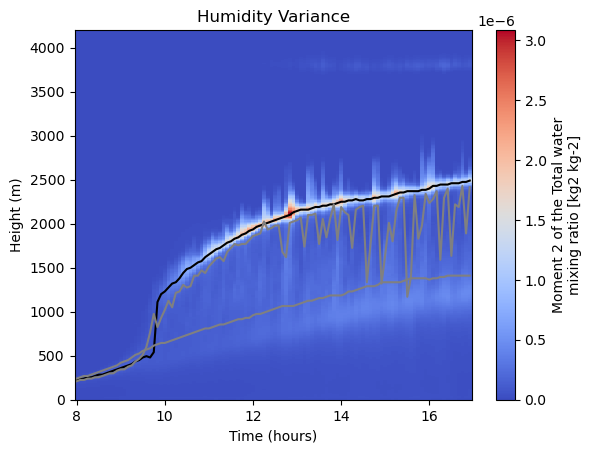

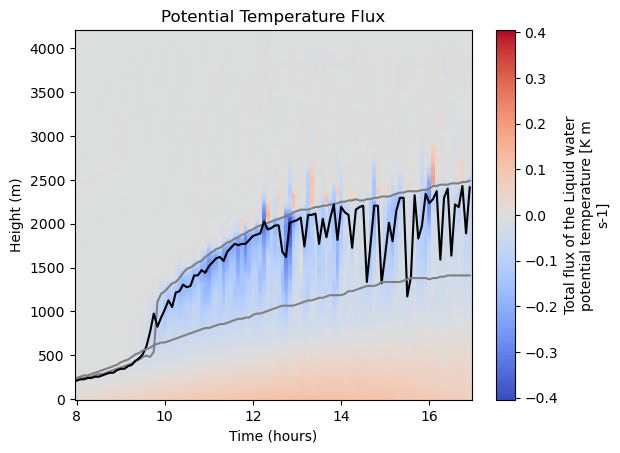

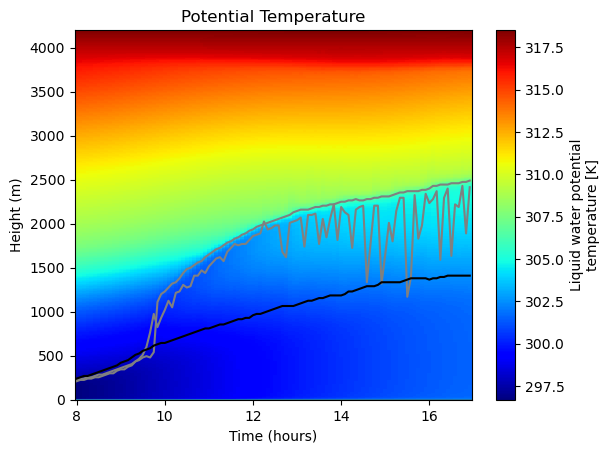

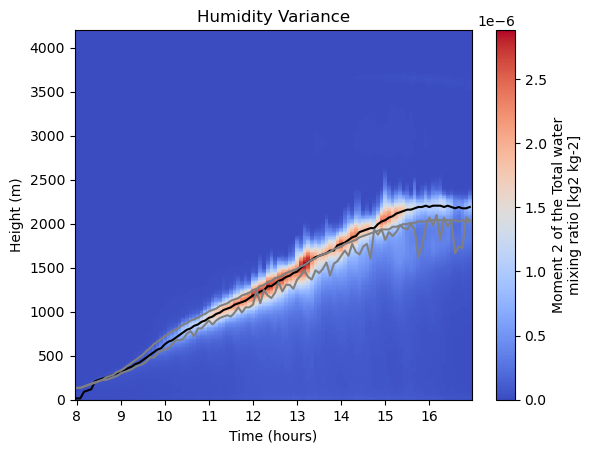

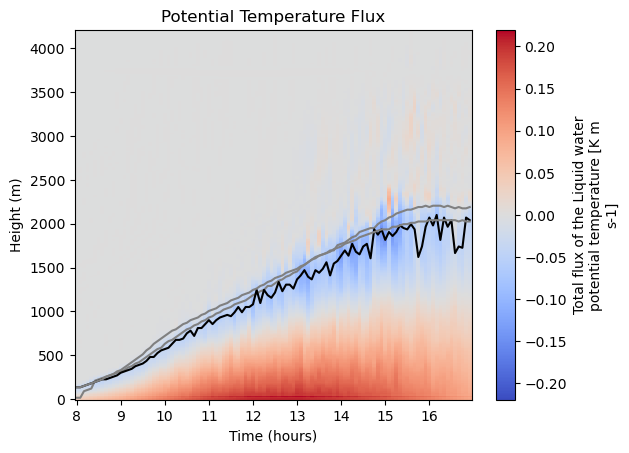

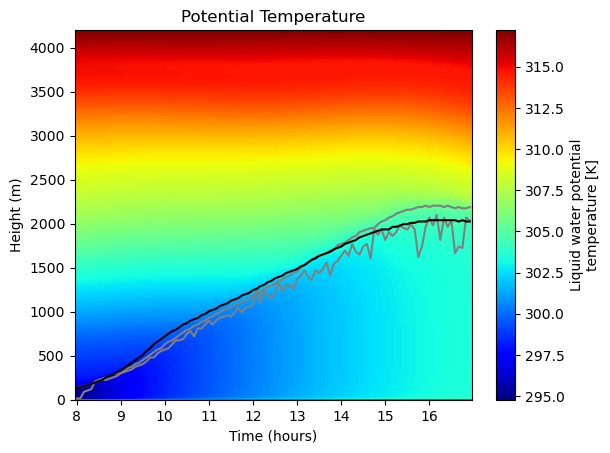

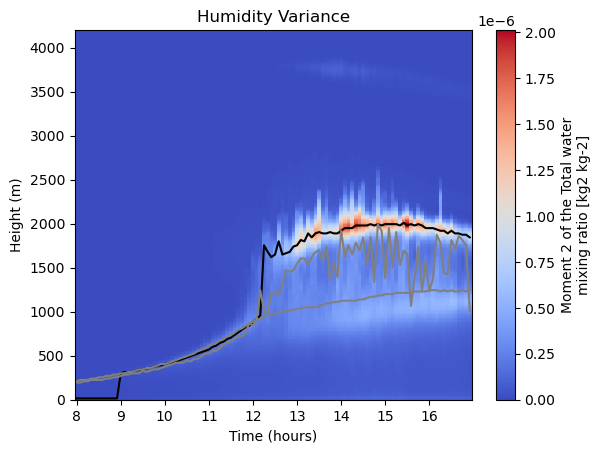

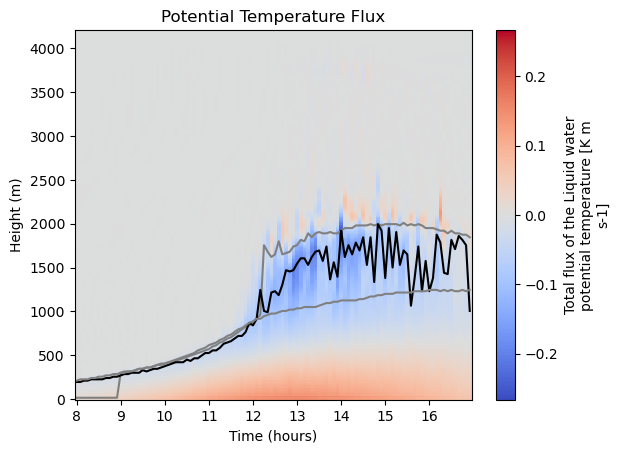

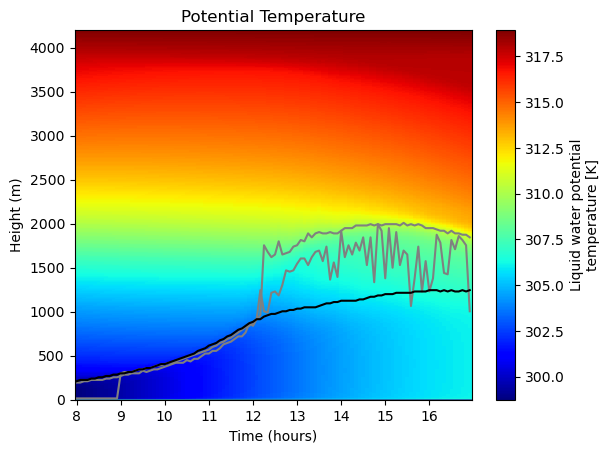

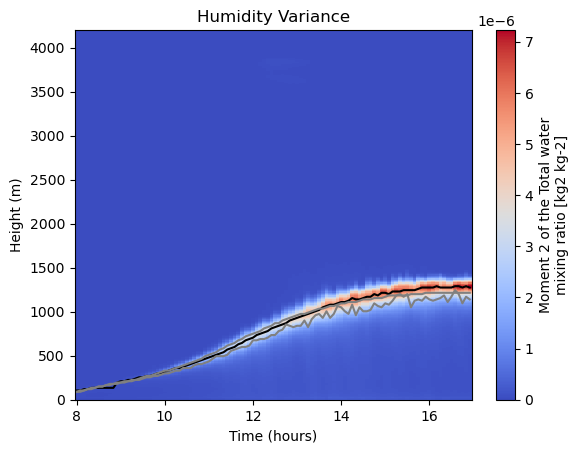

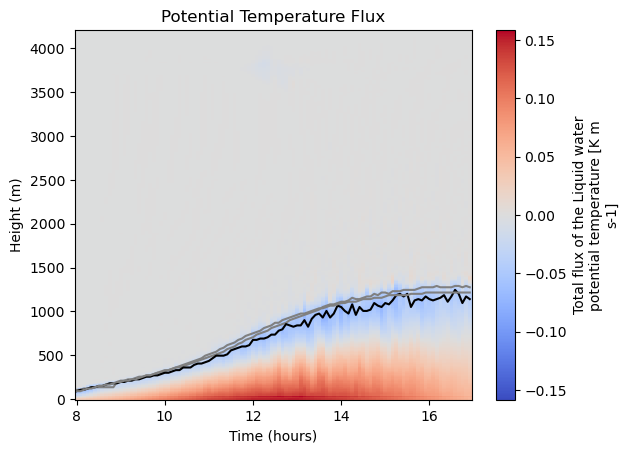

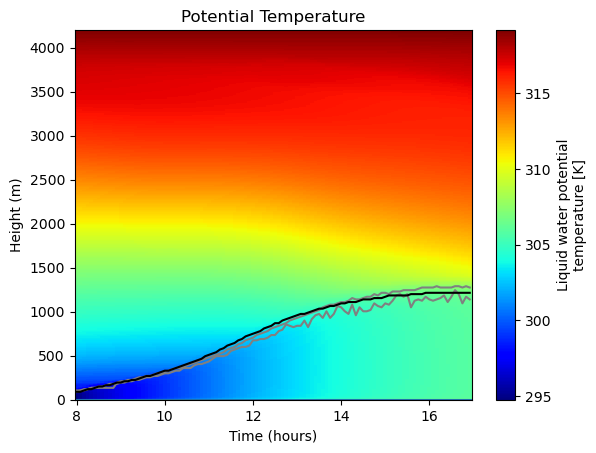

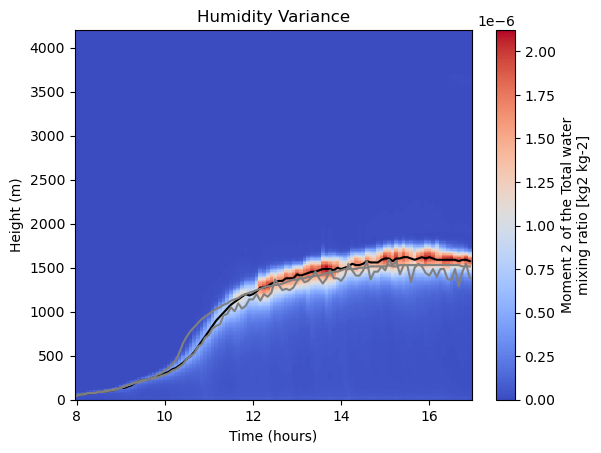

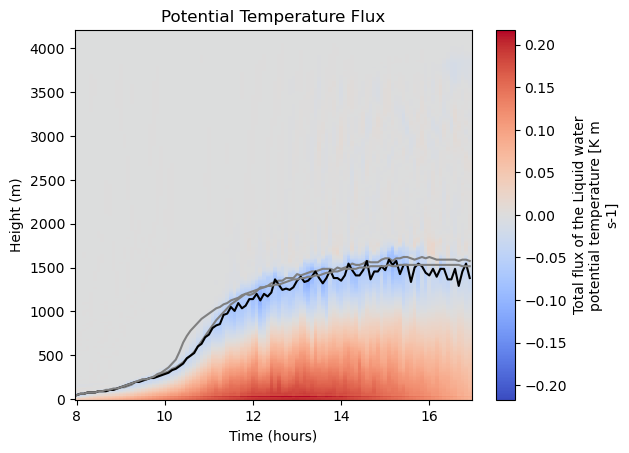

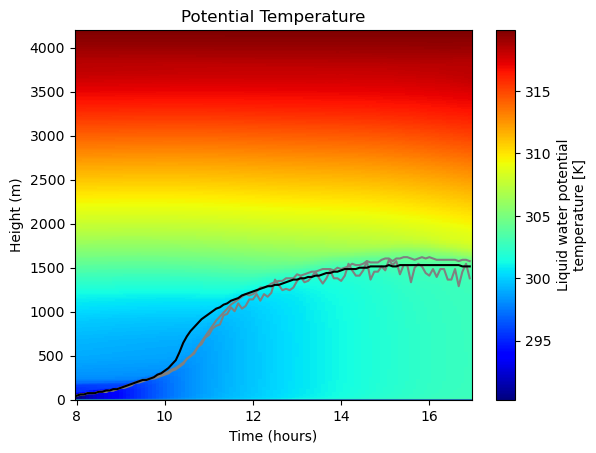

In [93]:
# do this for each directory and label the titles with the date
delta = 0.5*cp
for i in range(len(list_of_directories)):
    groups_slab = [''] + list(nc.Dataset(list_of_directories[i] + filenames_slab).groups.keys())
    prof_dict_slab = {}
    for group in groups_slab:
        prof_dict_slab[group] = xr.open_dataset(list_of_directories[i] + filenames_slab, group=group, decode_times=False)
    prof_slab = xr.merge(prof_dict_slab.values(), compat='override')
            
    kimptf = mptf(prof_slab['thl_flux'], prof_slab['time'])
    kilnb = lnb(prof_slab['thl'])
    kimhv = slabmhv(prof_slab)
    
    # Convert time to hours and set it as a new coordinate
    prof_slab = prof_slab.assign_coords(time_hours=(prof_slab['time'] / 3600)+3)
    time_hours = prof_slab['time_hours'][sr_slab:ss_slab]

    # plot the humidity variance
    plt.figure()
    prof_slab['qt_2'][sr_slab:ss_slab,:].plot(x='time_hours', cmap='coolwarm')
    plt.plot(time_hours, prof_slab['zh'][kimhv][sr_slab:ss_slab], 'k')
    plt.plot(time_hours, prof_slab['zh'][kimptf][sr_slab:ss_slab], 'grey')
    plt.plot(time_hours, prof_slab['zh'][kilnb][sr_slab:ss_slab], 'grey')
    plt.title('Humidity Variance')
    plt.ylabel('Height (m)')
    plt.xlabel('Time (hours)')
    
    # plot the potential temperature flux
    plt.figure()
    prof_slab['thl_flux'][sr_slab:ss_slab,:].plot(x='time_hours', cmap='coolwarm')
    plt.plot(time_hours, prof_slab['zh'][kimhv][sr_slab:ss_slab], 'grey')
    plt.plot(time_hours, prof_slab['zh'][kimptf][sr_slab:ss_slab], 'k')
    plt.plot(time_hours, prof_slab['zh'][kilnb][sr_slab:ss_slab], 'grey')
    plt.title('Potential Temperature Flux')
    plt.ylabel('Height (m)')
    plt.xlabel('Time (hours)')
    
    # plot the potential temperature
    plt.figure()
    prof_slab['thl'][sr_slab:ss_slab,:].plot(x='time_hours', cmap='jet')
    plt.plot(time_hours, prof_slab['zh'][kimhv][sr_slab:ss_slab], 'grey')
    plt.plot(time_hours, prof_slab['zh'][kimptf][sr_slab:ss_slab], 'grey')
    plt.plot(time_hours, prof_slab['zh'][kilnb][sr_slab:ss_slab], 'k')
    plt.title('Potential Temperature')
    plt.ylabel('Height (m)')
    plt.xlabel('Time (hours)')



Make an example single column MD that is not good to show closure
1. use a MD that does not have good closure (LNB col 0, 5)
2. draw a red arrow from the end of E2 to the end of the scalar
3. draw a dashed, magenta line from the end of advection to the end of the scalar

In [ ]:
# plot a MD using a single column i = 0, j = 5; BLtype = 'Level of Neutral Buoyancy'; Method = 'Normalized by zi'; Surface = 'Extrapolated to Surface'
i = 0
j = 5
u = prof_all['u'][i,j,:,:]
v = prof_all['v'][i,j,:,:]
wh = prof_all['w'][i,j,:,:] #w velocity defined at zh
w = wh.interp(time = time, zh = z) #take the vertical velocity at z instead of zh
thl = prof_all['thl'][i,j,:,:]*cp #K time, z
qt = np.multiply(prof_all['qt'][i,j,:,:]*Lv, 1) #kg/kg time, z
thlflux = flux(thl, w,one_window,dir)
qtflux = flux(qt, w,one_window,dir)
thlflux_surfacelayer = thlflux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})
qtflux_surfacelayer = qtflux[:,ksurf:].interp(z = np.linspace(0,150,11), kwargs = {'fill_value':'extrapolate'})


ki = lnb(thl)
ki = np.round(savgol_filter(ki, one_window, order)).astype(int)
ki = xr.DataArray(ki, coords={'time':time}, dims=['time'])
zi = zh[ki]
zi = xr.DataArray(zi, coords={'time':time}, dims=['time'])



qt_mean = savgol_filter(mean(qt,ki, time,0,False), one_window, order)
thl_mean = savgol_filter(mean(thl,ki, time,0,False), one_window, order)
qt_adv = advec(qtls,ki,time,dt)
thl_adv = advec(thlls,ki,time,dt)
qt_entr2 = entr2(qt,ki, ki,zi,time, wls, dt,0,False)
thl_entr2 = entr2(thl,ki,ki,zi, time, wls, dt,0,False)




# EXTRAPOLATED SURFACE FLUXES?
Surface = "Extrapolated to Surface"
qt_surf = surf(qtflux_surfacelayer,0, zi, dt, time)
thl_surf = surf(thlflux_surfacelayer,0,zi, dt, time)



Method = "Normalized by zi"
qt_entrflux = top_flux(qt,w,ki,one_window,dir)
thl_entrflux = top_flux(thl,w,ki,one_window,dir) 
qt_entr = entr(qt_entrflux,ki,zi,time,dt,normalized = True)
thl_entr = entr(thl_entrflux,ki,zi,time,dt, normalized = True)



# PLOT MIXING DIAGRAM
plt.figure() 
loc = 0
xarr = qt[sr:ss,loc] - qt[sr,loc]
yarr = thl[sr:ss,loc] - thl[sr,loc]
#plt.plot(xarr,yarr, 'gray', label = str(z[loc].values) +'-m Value')

xarr = qt_mean[sr:ss] - qt_mean[sr]
yarr = thl_mean[sr:ss] -thl_mean[sr]
xval = xarr[-1]
yval = yarr[-1]
plt.plot(xarr,yarr, 'k-', label = 'Scalar Value')

xarr = xarr[0] + add_term(qt_surf,sr,ss,dir)
yarr = yarr[0] + add_term(thl_surf,sr,ss,dir)
plt.plot(xarr,yarr, 'green', label = 'Surface Flux')

xarr = xarr[-1] + add_term(qt_adv,sr,ss,dir)
yarr = yarr[-1] + add_term(thl_adv,sr,ss,dir)
xls = xarr[-1]
yls = yarr[-1]
plt.plot(xarr,yarr,'blue', label = 'Large Scale')

xarr = xarr[-1] + add_term(qt_entr,sr,ss,dir)
yarr = yarr[-1] + add_term(thl_entr,sr,ss,dir)
plt.plot(xarr,yarr,'orange', linewidth = 4, label = 'Entrainment')

xarr = xarr[-1] + add_term(qt_entr2,sr,ss,dir)
yarr = yarr[-1] + add_term(thl_entr2,sr,ss,dir)
plt.plot(xarr,yarr,'gold', label = 'Entrainment 2')

thlclos = yval-yarr[-1]
qtclos =xval-xarr[-1]
clos=np.sqrt((qtclos)**2+(thlclos)**2)

# plot a red arrow from the last value of entrainment 2 to the last value of the scalar value
plt.arrow(xarr[-1], yarr[-1], xval-xarr[-1], yval-yarr[-1], head_width=0.1, head_length=0.1, fc='r', ec='r', label = 'Closure')

#plot a dashed magenta line from the last value of the large scale to the end of the scalar value
plt.plot([xls, xval], [yls, yval], 'm--', label = 'Residual')


plt.title(f"{ColNum}: {timeofday}\n Distance to Closure: {clos.values:.2f} kJ kg$^{-1}$", fontsize=14)
plt.legend()
plt.minorticks_on()
plt.xlim(-8,8)
plt.ylim(-1,15)
plt.axvline(x=0, color='grey', linestyle=':')
plt.axhline(y=0, color='grey', linestyle=':')
plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)    
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)    
plt.xlabel('$\\Delta L_vq$ $(kJ kg^{-1})$',fontsize = 14)
plt.ylabel('$\\Delta C_p \\theta$$ (kJ kg^{-1})$',fontsize = 14)
plt.savefig('/data/OneDrive/Tessa Rosenberger/methodologypaper/Example'+date+'_'+timeofday+'_'+ColNum+'_MD_'+BLtype+'.png')
